**Decentralized Tensorflow**

Here is some code for (non-privacy) containing a test model for dencentralized computing. Next steps are to add noise, and scale the size up.


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
accuracy for Node:  0   is:  0.14   at epoch:  0  test acc:  0.1222
accuracy for Node:  1   is:  0.04   at epoch:  0  test acc:  0.1007
accuracy for Node:  2   is:  0.16   at epoch:  0  test acc:  0.101
accuracy for Node:  3   is:  0.28   at epoch:  0  test acc:  0.0996
accuracy for Node:  0   is:  0.86   at epoch:  50  test acc:  0.8054
accuracy for Node:  1   is:  0.88   at epoch:  50  test acc:  0.8145
accuracy for Node:  2   is:  0.84   at epoch:  50  test acc:  0.8119
accuracy for Node:  3   is:  0.94   at epoch:  50  test acc:  0.7584
accuracy for Node:  0   is:  0.92   at epoch:  100  test acc:  0.8406
accuracy for Node:  1   is:  0.96   at epoch:  100  test acc:  0.8529
accuracy for Node:  2   is:  0.92   at epoch:  100  test acc:  0.8557
accuracy for Node:  3   is:  0.88   at epoch:  10

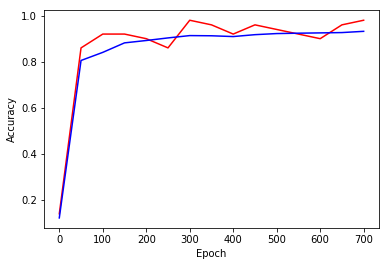

In [7]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.pyplot as plt
%matplotlib inline

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True

#Helper function to swap identities of gradients from one to the other.
def swapIdentity(gradient, newIdentity):
    return (gradient[0], newIdentity) #return new tuple with the identity replaced

def shp(x):
    return np.shape(x) 

tf.reset_default_graph()

#-----------------------Initialization---------------------------
#Hyperparameters:
theta_D = 1 #download rate
theta_U = 0.01 #Upload rate

sz = 4 # size of network

# Variables for our  4- way network
W1 = [tf.Variable(tf.truncated_normal([784, 500], stddev=0.1)) for i in range(sz)]
b1 = [tf.Variable(tf.zeros([500]))                             for i in range(sz)]
W2 = [tf.Variable(tf.truncated_normal([500, 100], stddev=0.1)) for i in range(sz)]
b2 = [tf.Variable(tf.zeros([100]))                             for i in range(sz)]
W3 = [tf.Variable(tf.truncated_normal([100, 10], stddev=0.1))  for i in range(sz)]
b3 = [tf.Variable(tf.zeros([10]))                              for i in range(sz)]

#Temporary gradient banks for communication between nodes (noise may be added in future)
g_W1 = [None for i in range(sz)]
g_W2 = [None for i in range(sz)]
g_W3 = [None for i in range(sz)]
g_b1 = [None for i in range(sz)]
g_b2 = [None for i in range(sz)]
g_b3 = [None for i in range(sz)]


grad_W1 = [[None for i in range(sz)] for i in range(sz)]
grad_W2 = [[None for i in range(sz)] for i in range(sz)]
grad_W3 = [[None for i in range(sz)] for i in range(sz)]
grad_b1 = [[None for i in range(sz)] for i in range(sz)]
grad_b2 = [[None for i in range(sz)] for i in range(sz)]
grad_b3 = [[None for i in range(sz)] for i in range(sz)]


#hidden layers, scores, etc. *Note there is somehow a problem with saying scores = loss = [None for i in range(sz)] so I put them in seperate lines
h1 = [None for i in range(sz)]
h2 = [None for i in range(sz)]

scores = [None for i in range(sz)]
loss = [None for i in range(sz)]

#-------------------------Define Decentralized Neural Network Structure-----------------

# Placeholders
X = [tf.placeholder(tf.float32, [None, 784])  for i in range(sz)]
y = [tf.placeholder(tf.float32, [None, 10])    for i in range(sz)]


# Deep Neural nets for 4 channels w/ loss function
for i in range(sz):
    h1[i] = tf.nn.relu(tf.matmul(X[i],  W1[i]) + b1[i])
    h2[i] = tf.nn.relu(tf.matmul(h1[i], W2[i]) + b2[i])
    scores[i] = tf.matmul(h2[i], W3[i]) + b3[i]
    loss[i] = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=scores[i], labels=y[i]))

# Gradient descent for 4 channels
train_one_step = [None for i in range(sz)]
opt =[None for i in range(sz)]

for i in range(sz):
    opt[i] = tf.train.GradientDescentOptimizer(0.05)
    train_one_step[i] = opt[i].minimize(loss[i])



correct_predictions = [0.0 for i in range(sz)]
accuracy = [0.0 for i in range(sz)]

# Accuracy indicator for 4 channels
for i in range(sz):
    correct_predictions[i] = tf.equal(tf.argmax(scores[i], axis=1), tf.argmax(y[i], axis=1))
    accuracy[i] = tf.reduce_mean(tf.cast(correct_predictions[i], tf.float32))

# Initialization of all decleared Tensors (above) in Tensorflow
init = tf.global_variables_initializer()

# Training
sess = tf.Session()
sess.run(init) #initalize all variables

#Gradient "bank"

train_acc=[0.0 for i in range(sz)]
train_loss=[0.0 for i in range(sz)]
test_acc = [0.0 for i in range(sz)]

send_gradients = [[None for i in range(sz)] for i in range(sz)]

#-----------------Build the gradients transfer graph---------------------
for cnode in range(sz):
    #compute local gradients
    g_W1[cnode], g_W2[cnode], g_W3[cnode], g_b1[cnode], g_b2[cnode], g_b3[cnode] = opt[cnode].compute_gradients(
            loss=loss[cnode], var_list=[W1[cnode], W2[cnode], W3[cnode], b1[cnode], b2[cnode], b3[cnode]])
    
    #EXperimennt around with either 1)dense, N(N-1)/2 connections, or 2)sparse graph, N connections
    for nei in range(sz): #Dense graph
    #for nei in [(cnode+1) % sz, cnode, (sz + cnode - 1) % sz]:
        #Distribute local gradients from current node to neighboring nodes
        grad_W1[cnode][nei] = swapIdentity(g_W1[cnode], W1[nei])
        grad_W2[cnode][nei] = swapIdentity(g_W2[cnode], W2[nei])
        grad_W3[cnode][nei] = swapIdentity(g_W3[cnode], W3[nei])
        grad_b1[cnode][nei] = swapIdentity(g_b1[cnode], b1[nei])
        grad_b2[cnode][nei] = swapIdentity(g_b2[cnode], b2[nei])
        grad_b3[cnode][nei] = swapIdentity(g_b3[cnode], b3[nei])
        
        send_gradients[cnode][nei] = opt[cnode].apply_gradients([
                                 grad_W1[cnode][nei], grad_W2[cnode][nei], grad_W3[cnode][nei], 
                                 grad_b1[cnode][nei], grad_b2[cnode][nei], grad_b3[cnode][nei]])

#------------------------------Begin Training------------------------------

#NOTE only for the first node (cnode = 0)
x_train = []
y_train = []

x_test = []
y_test = []

#Split data into 4-ths. (50,50,50,50)

for i in range(3000 // sz):
    
    for cnode in range(sz):      
        #---------download minibatch of 50 & get gradients-----------------------
        X_batch, y_batch = mnist.train.next_batch(50)
        
        #send gradients computed from current node to neighbors
        #for nei in [(cnode+1) % sz, cnode, (sz + cnode - 1) % sz]:
        for nei in range(sz):
            sess.run(send_gradients[cnode][nei], feed_dict={X[cnode]: X_batch, y[cnode]: y_batch})
        
        
            
        if(i % 50 == 0):
            
            train_acc[cnode] = sess.run(accuracy[cnode], feed_dict={X[cnode]: X_batch, y[cnode]: y_batch})
            test_acc[cnode] = sess.run(accuracy[cnode], feed_dict={X[cnode]: mnist.test.images, y[cnode]: mnist.test.labels})
            #PLOT ACCURACY OF FIRST NODE
            if(cnode == 0):
                x_train += [i]
                y_train += [train_acc[cnode]]
                
                x_test += [i]
                y_test += [test_acc[cnode]]
            print("accuracy for Node: ", cnode,  "  is: ",train_acc[cnode],  "  at epoch: ", i, " test acc: ", test_acc[cnode])
        
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(x_train, y_train, 'r', x_test, y_test, 'b')
        
# Make sure to print out your accuracy on the test set at the end.
print("Final accuracy on test set:")
for i in range(sz):
    print(i, " has accuracy: ", sess.run(accuracy[i], feed_dict={X[i]: mnist.test.images, y[i]: mnist.test.labels}))

**Decentralized Ring method**

Here, we'll test for all sizes sz=[1...15] and graph the maximum accruracy vs. size. Extension of above code 

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
accuracy for Node:  0   is:  0.12   at epoch:  0  test acc:  0.0877
accuracy for Node:  1   is:  0.08   at epoch:  0  test acc:  0.0916
accuracy for Node:  2   is:  0.28   at epoch:  0  test acc:  0.1333
accuracy for Node:  3   is:  0.22   at epoch:  0  test acc:  0.1751
accuracy for Node:  0   is:  0.9   at epoch:  50  test acc:  0.7777
accuracy for Node:  1   is:  0.82   at epoch:  50  test acc:  0.7744
accuracy for Node:  2   is:  0.94   at epoch:  50  test acc:  0.8052
accuracy for Node:  3   is:  0.82   at epoch:  50  test acc:  0.8079
accuracy for Node:  0   is:  0.94   at epoch:  100  test acc:  0.8614
accuracy for Node:  1   is:  0.92   at epoch:  100  test acc:  0.853
accuracy for Node:  2   is:  0.9   at epoch:  100  test acc:  0.835
accuracy for Node:  3   is:  0.98   at epoch:  100  

accuracy for Node:  0   is:  0.92   at epoch:  550  test acc:  0.9084
accuracy for Node:  1   is:  0.94   at epoch:  550  test acc:  0.9203
accuracy for Node:  2   is:  0.98   at epoch:  550  test acc:  0.9249
accuracy for Node:  3   is:  0.92   at epoch:  550  test acc:  0.9228
accuracy for Node:  4   is:  0.94   at epoch:  550  test acc:  0.9196
Final accuracy on test set:
0  has accuracy:  0.9199
1  has accuracy:  0.9293
2  has accuracy:  0.926
3  has accuracy:  0.9276
4  has accuracy:  0.9162
accuracy for Node:  0   is:  0.2   at epoch:  0  test acc:  0.1029
accuracy for Node:  1   is:  0.14   at epoch:  0  test acc:  0.0929
accuracy for Node:  2   is:  0.24   at epoch:  0  test acc:  0.1698
accuracy for Node:  3   is:  0.36   at epoch:  0  test acc:  0.1832
accuracy for Node:  4   is:  0.06   at epoch:  0  test acc:  0.1039
accuracy for Node:  5   is:  0.34   at epoch:  0  test acc:  0.1407
accuracy for Node:  0   is:  0.84   at epoch:  50  test acc:  0.802
accuracy for Node:  1  

accuracy for Node:  0   is:  0.98   at epoch:  350  test acc:  0.9148
accuracy for Node:  1   is:  0.92   at epoch:  350  test acc:  0.91
accuracy for Node:  2   is:  0.98   at epoch:  350  test acc:  0.9185
accuracy for Node:  3   is:  0.96   at epoch:  350  test acc:  0.9114
accuracy for Node:  4   is:  0.96   at epoch:  350  test acc:  0.9062
accuracy for Node:  5   is:  0.94   at epoch:  350  test acc:  0.9136
accuracy for Node:  6   is:  0.98   at epoch:  350  test acc:  0.9156
accuracy for Node:  0   is:  0.98   at epoch:  400  test acc:  0.92
accuracy for Node:  1   is:  0.98   at epoch:  400  test acc:  0.9094
accuracy for Node:  2   is:  0.92   at epoch:  400  test acc:  0.9084
accuracy for Node:  3   is:  0.96   at epoch:  400  test acc:  0.9177
accuracy for Node:  4   is:  1.0   at epoch:  400  test acc:  0.9079
accuracy for Node:  5   is:  0.92   at epoch:  400  test acc:  0.9012
accuracy for Node:  6   is:  1.0   at epoch:  400  test acc:  0.9089
Final accuracy on test set

accuracy for Node:  0   is:  0.94   at epoch:  200  test acc:  0.8943
accuracy for Node:  1   is:  0.92   at epoch:  200  test acc:  0.8847
accuracy for Node:  2   is:  0.98   at epoch:  200  test acc:  0.8918
accuracy for Node:  3   is:  0.96   at epoch:  200  test acc:  0.8926
accuracy for Node:  4   is:  0.96   at epoch:  200  test acc:  0.8983
accuracy for Node:  5   is:  0.92   at epoch:  200  test acc:  0.893
accuracy for Node:  6   is:  0.9   at epoch:  200  test acc:  0.8908
accuracy for Node:  7   is:  1.0   at epoch:  200  test acc:  0.887
accuracy for Node:  8   is:  0.92   at epoch:  200  test acc:  0.8995
accuracy for Node:  0   is:  0.88   at epoch:  250  test acc:  0.8994
accuracy for Node:  1   is:  0.88   at epoch:  250  test acc:  0.8968
accuracy for Node:  2   is:  0.96   at epoch:  250  test acc:  0.8892
accuracy for Node:  3   is:  0.92   at epoch:  250  test acc:  0.8933
accuracy for Node:  4   is:  0.98   at epoch:  250  test acc:  0.9071
accuracy for Node:  5   

accuracy for Node:  0   is:  1.0   at epoch:  150  test acc:  0.8875
accuracy for Node:  1   is:  0.86   at epoch:  150  test acc:  0.8623
accuracy for Node:  2   is:  0.94   at epoch:  150  test acc:  0.8874
accuracy for Node:  3   is:  0.98   at epoch:  150  test acc:  0.8884
accuracy for Node:  4   is:  0.86   at epoch:  150  test acc:  0.8706
accuracy for Node:  5   is:  0.94   at epoch:  150  test acc:  0.8843
accuracy for Node:  6   is:  0.88   at epoch:  150  test acc:  0.8834
accuracy for Node:  7   is:  0.92   at epoch:  150  test acc:  0.8739
accuracy for Node:  8   is:  0.86   at epoch:  150  test acc:  0.8521
accuracy for Node:  9   is:  0.88   at epoch:  150  test acc:  0.8709
accuracy for Node:  10   is:  0.92   at epoch:  150  test acc:  0.8621
accuracy for Node:  0   is:  0.9   at epoch:  200  test acc:  0.8822
accuracy for Node:  1   is:  0.9   at epoch:  200  test acc:  0.8903
accuracy for Node:  2   is:  0.94   at epoch:  200  test acc:  0.8856
accuracy for Node:  3 

accuracy for Node:  12   is:  0.82   at epoch:  50  test acc:  0.815
accuracy for Node:  0   is:  0.92   at epoch:  100  test acc:  0.8363
accuracy for Node:  1   is:  0.78   at epoch:  100  test acc:  0.8442
accuracy for Node:  2   is:  0.9   at epoch:  100  test acc:  0.8349
accuracy for Node:  3   is:  0.88   at epoch:  100  test acc:  0.8729
accuracy for Node:  4   is:  0.84   at epoch:  100  test acc:  0.8533
accuracy for Node:  5   is:  0.92   at epoch:  100  test acc:  0.8635
accuracy for Node:  6   is:  0.88   at epoch:  100  test acc:  0.8747
accuracy for Node:  7   is:  0.92   at epoch:  100  test acc:  0.8444
accuracy for Node:  8   is:  0.9   at epoch:  100  test acc:  0.8624
accuracy for Node:  9   is:  0.98   at epoch:  100  test acc:  0.8297
accuracy for Node:  10   is:  0.92   at epoch:  100  test acc:  0.8694
accuracy for Node:  11   is:  0.82   at epoch:  100  test acc:  0.8168
accuracy for Node:  12   is:  0.86   at epoch:  100  test acc:  0.8642
accuracy for Node:  

accuracy for Node:  0   is:  0.16   at epoch:  0  test acc:  0.0879
accuracy for Node:  1   is:  0.24   at epoch:  0  test acc:  0.1381
accuracy for Node:  2   is:  0.2   at epoch:  0  test acc:  0.1787
accuracy for Node:  3   is:  0.1   at epoch:  0  test acc:  0.0957
accuracy for Node:  4   is:  0.12   at epoch:  0  test acc:  0.1187
accuracy for Node:  5   is:  0.18   at epoch:  0  test acc:  0.1174
accuracy for Node:  6   is:  0.16   at epoch:  0  test acc:  0.1154
accuracy for Node:  7   is:  0.16   at epoch:  0  test acc:  0.1205
accuracy for Node:  8   is:  0.18   at epoch:  0  test acc:  0.0969
accuracy for Node:  9   is:  0.18   at epoch:  0  test acc:  0.1973
accuracy for Node:  10   is:  0.22   at epoch:  0  test acc:  0.1489
accuracy for Node:  11   is:  0.26   at epoch:  0  test acc:  0.1301
accuracy for Node:  12   is:  0.08   at epoch:  0  test acc:  0.1161
accuracy for Node:  13   is:  0.22   at epoch:  0  test acc:  0.1202
accuracy for Node:  14   is:  0.28   at epoch:

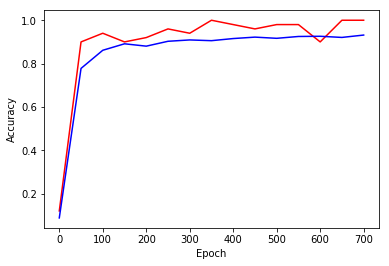

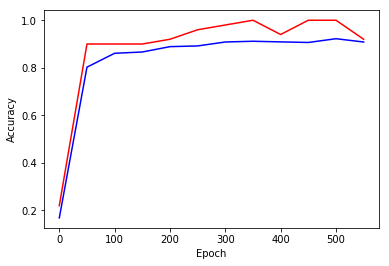

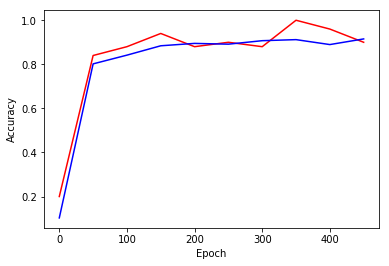

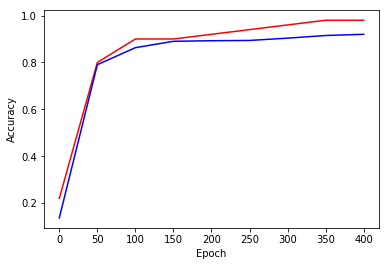

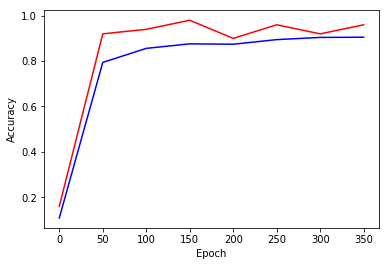

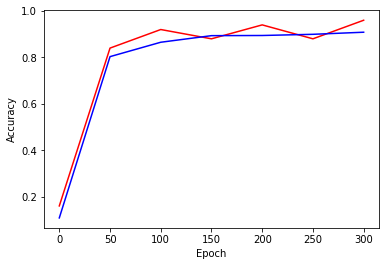

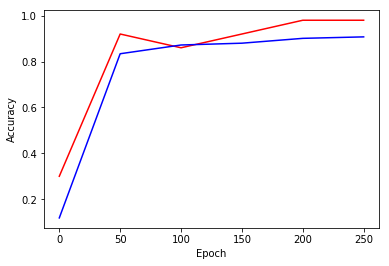

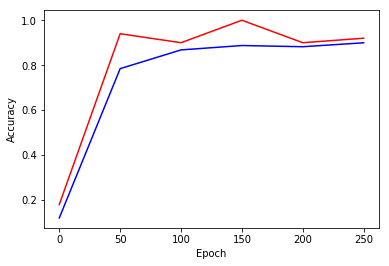

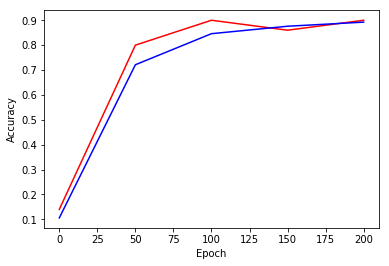

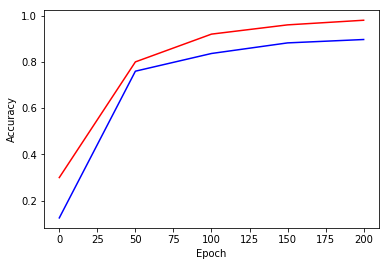

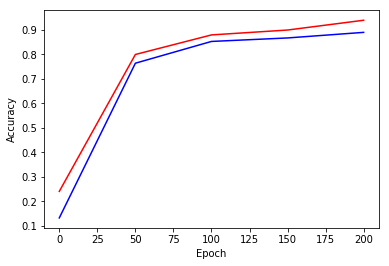

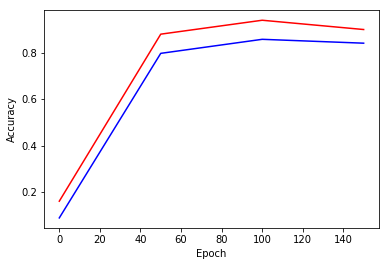

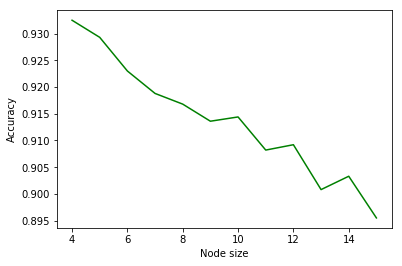

In [15]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.pyplot as plt
%matplotlib inline

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True

#Helper function to swap identities of gradients from one to the other.
def swapIdentity(gradient, newIdentity):
    return (gradient[0], newIdentity) #return new tuple with the identity replaced

def shp(x):
    return np.shape(x) 

tf.reset_default_graph()

#-----------------------Initialization---------------------------
#Hyperparameters:
theta_D = 1 #download rate
theta_U = 0.01 #Upload rate

#sz = 4 # size of network
node_sz = []
accs = []

for sz in range(4,16):
    # Variables for our  4- way network
    W1 = [tf.Variable(tf.truncated_normal([784, 500], stddev=0.1)) for i in range(sz)]
    b1 = [tf.Variable(tf.zeros([500]))                             for i in range(sz)]
    W2 = [tf.Variable(tf.truncated_normal([500, 100], stddev=0.1)) for i in range(sz)]
    b2 = [tf.Variable(tf.zeros([100]))                             for i in range(sz)]
    W3 = [tf.Variable(tf.truncated_normal([100, 10], stddev=0.1))  for i in range(sz)]
    b3 = [tf.Variable(tf.zeros([10]))                              for i in range(sz)]

    #Temporary gradient banks for communication between nodes (noise may be added in future)
    g_W1 = [None for i in range(sz)]
    g_W2 = [None for i in range(sz)]
    g_W3 = [None for i in range(sz)]
    g_b1 = [None for i in range(sz)]
    g_b2 = [None for i in range(sz)]
    g_b3 = [None for i in range(sz)]


    grad_W1 = [[None for i in range(sz)] for i in range(sz)]
    grad_W2 = [[None for i in range(sz)] for i in range(sz)]
    grad_W3 = [[None for i in range(sz)] for i in range(sz)]
    grad_b1 = [[None for i in range(sz)] for i in range(sz)]
    grad_b2 = [[None for i in range(sz)] for i in range(sz)]
    grad_b3 = [[None for i in range(sz)] for i in range(sz)]


    #hidden layers, scores, etc. *Note there is somehow a problem with saying scores = loss = [None for i in range(sz)] so I put them in seperate lines
    h1 = [None for i in range(sz)]
    h2 = [None for i in range(sz)]

    scores = [None for i in range(sz)]
    loss = [None for i in range(sz)]

    #-------------------------Define Decentralized Neural Network Structure-----------------

    # Placeholders
    X = [tf.placeholder(tf.float32, [None, 784])  for i in range(sz)]
    y = [tf.placeholder(tf.float32, [None, 10])    for i in range(sz)]


    # Deep Neural nets for 4 channels w/ loss function
    for i in range(sz):
        h1[i] = tf.nn.relu(tf.matmul(X[i],  W1[i]) + b1[i])
        h2[i] = tf.nn.relu(tf.matmul(h1[i], W2[i]) + b2[i])
        scores[i] = tf.matmul(h2[i], W3[i]) + b3[i]
        loss[i] = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=scores[i], labels=y[i]))

    # Gradient descent for 4 channels
    train_one_step = [None for i in range(sz)]
    opt =[None for i in range(sz)]

    for i in range(sz):
        opt[i] = tf.train.GradientDescentOptimizer(0.05)
        train_one_step[i] = opt[i].minimize(loss[i])



    correct_predictions = [0.0 for i in range(sz)]
    accuracy = [0.0 for i in range(sz)]

    # Accuracy indicator for 4 channels
    for i in range(sz):
        correct_predictions[i] = tf.equal(tf.argmax(scores[i], axis=1), tf.argmax(y[i], axis=1))
        accuracy[i] = tf.reduce_mean(tf.cast(correct_predictions[i], tf.float32))

    # Initialization of all decleared Tensors (above) in Tensorflow
    init = tf.global_variables_initializer()

    # Training
    sess = tf.Session()
    sess.run(init) #initalize all variables

    #Gradient "bank"

    train_acc=[0.0 for i in range(sz)]
    train_loss=[0.0 for i in range(sz)]
    test_acc = [0.0 for i in range(sz)]

    send_gradients = [[None for i in range(sz)] for i in range(sz)]

    #-----------------Build the gradients transfer graph---------------------
    for cnode in range(sz):
        #compute local gradients
        g_W1[cnode], g_W2[cnode], g_W3[cnode], g_b1[cnode], g_b2[cnode], g_b3[cnode] = opt[cnode].compute_gradients(
                loss=loss[cnode], var_list=[W1[cnode], W2[cnode], W3[cnode], b1[cnode], b2[cnode], b3[cnode]])

        #EXperimennt around with either 1)dense, N(N-1)/2 connections, or 2)sparse graph, N connections
        #for nei in range(sz): #Dense graph
        for nei in [(cnode+1) % sz, cnode, (sz + cnode - 1) % sz]:
            #Distribute local gradients from current node to neighboring nodes
            grad_W1[cnode][nei] = swapIdentity(g_W1[cnode], W1[nei])
            grad_W2[cnode][nei] = swapIdentity(g_W2[cnode], W2[nei])
            grad_W3[cnode][nei] = swapIdentity(g_W3[cnode], W3[nei])
            grad_b1[cnode][nei] = swapIdentity(g_b1[cnode], b1[nei])
            grad_b2[cnode][nei] = swapIdentity(g_b2[cnode], b2[nei])
            grad_b3[cnode][nei] = swapIdentity(g_b3[cnode], b3[nei])

            send_gradients[cnode][nei] = opt[cnode].apply_gradients([
                                     grad_W1[cnode][nei], grad_W2[cnode][nei], grad_W3[cnode][nei], 
                                     grad_b1[cnode][nei], grad_b2[cnode][nei], grad_b3[cnode][nei]])

    #------------------------------Begin Training------------------------------

    #NOTE only for the first node (cnode = 0)
    x_train = []
    y_train = []

    x_test = []
    y_test = []

    #Split data into 4-ths. (50,50,50,50)

    for i in range(3000 // sz):

        for cnode in range(sz):      
            #---------download minibatch of 50 & get gradients-----------------------
            X_batch, y_batch = mnist.train.next_batch(50)

            #send gradients computed from current node to neighbors
            for nei in [(cnode+1) % sz, cnode, (sz + cnode - 1) % sz]:
            #for nei in range(sz):
                sess.run(send_gradients[cnode][nei], feed_dict={X[cnode]: X_batch, y[cnode]: y_batch})



            if(i % 50 == 0):
                train_acc[cnode] = sess.run(accuracy[cnode], feed_dict={X[cnode]: X_batch, y[cnode]: y_batch})
                test_acc[cnode] = sess.run(accuracy[cnode], feed_dict={X[cnode]: mnist.test.images, y[cnode]: mnist.test.labels})
                #PLOT ACCURACY OF FIRST NODE
                if(cnode == 0):
                    x_train += [i]
                    y_train += [train_acc[cnode]]

                    x_test += [i]
                    y_test += [test_acc[cnode]]
                print("accuracy for Node: ", cnode,  "  is: ",train_acc[cnode],  "  at epoch: ", i, " test acc: ", test_acc[cnode])

    #after done with training (for i loop), get FINAL test set accuracy for export.
    plt.figure(sz)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(x_train, y_train, 'r', x_test, y_test, 'b')
    
    maxacc = 0
    # Make sure to print out your accuracy on the test set at the end.
    print("Final accuracy on test set:")
    for i in range(sz):
        accy =  sess.run(accuracy[i], feed_dict={X[i]: mnist.test.images, y[i]: mnist.test.labels})
        print(i, " has accuracy: ",accy)
        maxacc = max(maxacc, accy)
    
    node_sz += [sz]
    accs += [maxacc]


#FINAL PLOT for the #of Agents (Node size) vs. accuracy (max of all agents) 
plt.figure(16)
plt.xlabel('Node size')
plt.ylabel('Accuracy')
plt.plot(node_sz, accs, 'g')



In [11]:
[i for i in range(1,16)]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

**Comparison of Ring (~N connections between gradients) vs dense network (~N(N-1)/2 connections) vs. alone**

We will do comparison for larger tasks, bigger connnections :)



/home/patrick/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/patrick/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
accuracy for Node:  0   is:  0.26   at epoch:  0  test acc:  0.1493
accuracy for Node:  1   is:  0.22   at epoch:  0  test acc:  0.1257
accuracy for Node:  2   is:  0.16   at epoch:  0  test acc:  0.1165
accuracy for Node:  3   is:  0.24   at epoch:  0  test acc:  0.1235
accuracy for Node:  4   is:  0.3   at epoch:  0  test acc:  0.1829
accuracy for Node:  5   is:  0.2   at epoch:  0  test acc:  0.1722
accuracy for Node:  6   is:  0.18   at epoch:  0  test acc:  0.1312
accuracy for Node:  7   is:  0.1   at epoch:  0  test acc:  0.1005
accuracy for Node:  8   is:  0.26   at epoch:  0  test acc:  0.1707
accuracy for Node:  9   is:  0.24   at epoch:  0  test acc:  0.173
accuracy for Node:  10   is:  0.14   at epoch:  0  test acc:  0.1142
accuracy for Node:  11   is:  0.2   at epoch:  0  test acc:  

accuracy for Node:  8   is:  0.24   at epoch:  0  test acc:  0.1421
accuracy for Node:  9   is:  0.28   at epoch:  0  test acc:  0.1545
accuracy for Node:  10   is:  0.28   at epoch:  0  test acc:  0.1474
accuracy for Node:  11   is:  0.14   at epoch:  0  test acc:  0.0972
accuracy for Node:  12   is:  0.16   at epoch:  0  test acc:  0.0948
accuracy for Node:  13   is:  0.2   at epoch:  0  test acc:  0.1544
accuracy for Node:  14   is:  0.22   at epoch:  0  test acc:  0.1483
accuracy for Node:  15   is:  0.18   at epoch:  0  test acc:  0.1313
accuracy for Node:  16   is:  0.22   at epoch:  0  test acc:  0.1364
accuracy for Node:  17   is:  0.3   at epoch:  0  test acc:  0.1931
accuracy for Node:  18   is:  0.18   at epoch:  0  test acc:  0.0993
accuracy for Node:  19   is:  0.18   at epoch:  0  test acc:  0.1168
accuracy for Node:  20   is:  0.22   at epoch:  0  test acc:  0.1181
accuracy for Node:  0   is:  0.76   at epoch:  50  test acc:  0.7773
accuracy for Node:  1   is:  0.88   at

accuracy for Node:  19   is:  0.84   at epoch:  50  test acc:  0.7606
accuracy for Node:  20   is:  0.9   at epoch:  50  test acc:  0.7822
accuracy for Node:  21   is:  0.84   at epoch:  50  test acc:  0.8045
accuracy for Node:  0   is:  0.88   at epoch:  100  test acc:  0.8507
accuracy for Node:  1   is:  0.86   at epoch:  100  test acc:  0.8635
accuracy for Node:  2   is:  0.88   at epoch:  100  test acc:  0.8654
accuracy for Node:  3   is:  0.9   at epoch:  100  test acc:  0.8654
accuracy for Node:  4   is:  0.9   at epoch:  100  test acc:  0.8392
accuracy for Node:  5   is:  0.92   at epoch:  100  test acc:  0.8179
accuracy for Node:  6   is:  0.88   at epoch:  100  test acc:  0.8542
accuracy for Node:  7   is:  0.92   at epoch:  100  test acc:  0.8572
accuracy for Node:  8   is:  0.94   at epoch:  100  test acc:  0.8694
accuracy for Node:  9   is:  0.9   at epoch:  100  test acc:  0.8593
accuracy for Node:  10   is:  0.88   at epoch:  100  test acc:  0.8575
accuracy for Node:  11 

accuracy for Node:  19   is:  0.92   at epoch:  100  test acc:  0.865
accuracy for Node:  20   is:  0.98   at epoch:  100  test acc:  0.86
accuracy for Node:  21   is:  0.9   at epoch:  100  test acc:  0.8623
accuracy for Node:  22   is:  0.84   at epoch:  100  test acc:  0.8585
accuracy for Node:  0   is:  0.9   at epoch:  150  test acc:  0.8875
accuracy for Node:  1   is:  0.94   at epoch:  150  test acc:  0.888
accuracy for Node:  2   is:  0.94   at epoch:  150  test acc:  0.8524
accuracy for Node:  3   is:  0.94   at epoch:  150  test acc:  0.8745
accuracy for Node:  4   is:  0.92   at epoch:  150  test acc:  0.8749
accuracy for Node:  5   is:  0.94   at epoch:  150  test acc:  0.8737
accuracy for Node:  6   is:  0.88   at epoch:  150  test acc:  0.8832
accuracy for Node:  7   is:  0.96   at epoch:  150  test acc:  0.8869
accuracy for Node:  8   is:  0.9   at epoch:  150  test acc:  0.8796
accuracy for Node:  9   is:  0.96   at epoch:  150  test acc:  0.8859
accuracy for Node:  10 

accuracy for Node:  19   is:  0.96   at epoch:  150  test acc:  0.8775
accuracy for Node:  20   is:  0.96   at epoch:  150  test acc:  0.8821
accuracy for Node:  21   is:  0.94   at epoch:  150  test acc:  0.8891
accuracy for Node:  22   is:  0.9   at epoch:  150  test acc:  0.8815
accuracy for Node:  23   is:  0.94   at epoch:  150  test acc:  0.8857
Final accuracy on test set:
0  has accuracy:  0.8729
1  has accuracy:  0.8812
2  has accuracy:  0.8901
3  has accuracy:  0.8799
4  has accuracy:  0.8935
5  has accuracy:  0.8958
6  has accuracy:  0.8362
7  has accuracy:  0.8829
8  has accuracy:  0.8992
9  has accuracy:  0.8788
10  has accuracy:  0.8887
11  has accuracy:  0.8932
12  has accuracy:  0.8758
13  has accuracy:  0.8632
14  has accuracy:  0.8868
15  has accuracy:  0.8888
16  has accuracy:  0.8913
17  has accuracy:  0.8874
18  has accuracy:  0.8929
19  has accuracy:  0.8862
20  has accuracy:  0.8883
21  has accuracy:  0.8892
22  has accuracy:  0.8814
23  has accuracy:  0.8931
accu

accuracy for Node:  0   is:  0.2   at epoch:  0  test acc:  0.1302
accuracy for Node:  1   is:  0.26   at epoch:  0  test acc:  0.1147
accuracy for Node:  2   is:  0.18   at epoch:  0  test acc:  0.1363
accuracy for Node:  3   is:  0.38   at epoch:  0  test acc:  0.1115
accuracy for Node:  4   is:  0.22   at epoch:  0  test acc:  0.121
accuracy for Node:  5   is:  0.28   at epoch:  0  test acc:  0.1046
accuracy for Node:  6   is:  0.16   at epoch:  0  test acc:  0.1042
accuracy for Node:  7   is:  0.18   at epoch:  0  test acc:  0.1457
accuracy for Node:  8   is:  0.2   at epoch:  0  test acc:  0.1082
accuracy for Node:  9   is:  0.16   at epoch:  0  test acc:  0.1262
accuracy for Node:  10   is:  0.2   at epoch:  0  test acc:  0.1369
accuracy for Node:  11   is:  0.24   at epoch:  0  test acc:  0.1826
accuracy for Node:  12   is:  0.12   at epoch:  0  test acc:  0.1309
accuracy for Node:  13   is:  0.26   at epoch:  0  test acc:  0.118
accuracy for Node:  14   is:  0.22   at epoch:  0

accuracy for Node:  4   is:  0.16   at epoch:  0  test acc:  0.1259
accuracy for Node:  5   is:  0.18   at epoch:  0  test acc:  0.126
accuracy for Node:  6   is:  0.24   at epoch:  0  test acc:  0.0781
accuracy for Node:  7   is:  0.2   at epoch:  0  test acc:  0.1152
accuracy for Node:  8   is:  0.14   at epoch:  0  test acc:  0.1033
accuracy for Node:  9   is:  0.26   at epoch:  0  test acc:  0.1267
accuracy for Node:  10   is:  0.38   at epoch:  0  test acc:  0.1857
accuracy for Node:  11   is:  0.24   at epoch:  0  test acc:  0.1634
accuracy for Node:  12   is:  0.22   at epoch:  0  test acc:  0.1369
accuracy for Node:  13   is:  0.26   at epoch:  0  test acc:  0.1407
accuracy for Node:  14   is:  0.2   at epoch:  0  test acc:  0.1208
accuracy for Node:  15   is:  0.16   at epoch:  0  test acc:  0.0833
accuracy for Node:  16   is:  0.12   at epoch:  0  test acc:  0.1527
accuracy for Node:  17   is:  0.26   at epoch:  0  test acc:  0.1468
accuracy for Node:  18   is:  0.22   at epo

accuracy for Node:  4   is:  0.08   at epoch:  0  test acc:  0.107
accuracy for Node:  5   is:  0.18   at epoch:  0  test acc:  0.1409
accuracy for Node:  6   is:  0.16   at epoch:  0  test acc:  0.0933
accuracy for Node:  7   is:  0.14   at epoch:  0  test acc:  0.14
accuracy for Node:  8   is:  0.32   at epoch:  0  test acc:  0.1497
accuracy for Node:  9   is:  0.24   at epoch:  0  test acc:  0.1372
accuracy for Node:  10   is:  0.22   at epoch:  0  test acc:  0.1237
accuracy for Node:  11   is:  0.12   at epoch:  0  test acc:  0.1323
accuracy for Node:  12   is:  0.24   at epoch:  0  test acc:  0.1274
accuracy for Node:  13   is:  0.28   at epoch:  0  test acc:  0.1577
accuracy for Node:  14   is:  0.14   at epoch:  0  test acc:  0.1289
accuracy for Node:  15   is:  0.28   at epoch:  0  test acc:  0.1308
accuracy for Node:  16   is:  0.1   at epoch:  0  test acc:  0.0776
accuracy for Node:  17   is:  0.28   at epoch:  0  test acc:  0.1622
accuracy for Node:  18   is:  0.22   at epoc

accuracy for Node:  28   is:  0.26   at epoch:  0  test acc:  0.167
accuracy for Node:  0   is:  0.84   at epoch:  50  test acc:  0.7414
accuracy for Node:  1   is:  0.84   at epoch:  50  test acc:  0.8107
accuracy for Node:  2   is:  0.88   at epoch:  50  test acc:  0.7825
accuracy for Node:  3   is:  0.84   at epoch:  50  test acc:  0.802
accuracy for Node:  4   is:  0.92   at epoch:  50  test acc:  0.8008
accuracy for Node:  5   is:  0.8   at epoch:  50  test acc:  0.8192
accuracy for Node:  6   is:  0.84   at epoch:  50  test acc:  0.8153
accuracy for Node:  7   is:  0.86   at epoch:  50  test acc:  0.8067
accuracy for Node:  8   is:  0.88   at epoch:  50  test acc:  0.8226
accuracy for Node:  9   is:  0.92   at epoch:  50  test acc:  0.82
accuracy for Node:  10   is:  0.84   at epoch:  50  test acc:  0.8167
accuracy for Node:  11   is:  0.86   at epoch:  50  test acc:  0.8171
accuracy for Node:  12   is:  0.86   at epoch:  50  test acc:  0.7756
accuracy for Node:  13   is:  0.86  

accuracy for Node:  10   is:  0.88   at epoch:  100  test acc:  0.8276
accuracy for Node:  11   is:  0.82   at epoch:  100  test acc:  0.8317
accuracy for Node:  12   is:  0.88   at epoch:  100  test acc:  0.8478
accuracy for Node:  13   is:  0.86   at epoch:  100  test acc:  0.86
accuracy for Node:  14   is:  0.84   at epoch:  100  test acc:  0.8508
accuracy for Node:  15   is:  0.9   at epoch:  100  test acc:  0.8783
accuracy for Node:  16   is:  0.9   at epoch:  100  test acc:  0.871
accuracy for Node:  17   is:  0.98   at epoch:  100  test acc:  0.8664
accuracy for Node:  18   is:  0.88   at epoch:  100  test acc:  0.8587
accuracy for Node:  19   is:  0.8   at epoch:  100  test acc:  0.7842
accuracy for Node:  0   is:  0.9   at epoch:  150  test acc:  0.8636
accuracy for Node:  1   is:  0.94   at epoch:  150  test acc:  0.8694
accuracy for Node:  2   is:  0.82   at epoch:  150  test acc:  0.8636
accuracy for Node:  3   is:  0.92   at epoch:  150  test acc:  0.8746
accuracy for Node

accuracy for Node:  0   is:  0.8   at epoch:  150  test acc:  0.8392
accuracy for Node:  1   is:  0.86   at epoch:  150  test acc:  0.8769
accuracy for Node:  2   is:  0.96   at epoch:  150  test acc:  0.8824
accuracy for Node:  3   is:  0.9   at epoch:  150  test acc:  0.8823
accuracy for Node:  4   is:  0.94   at epoch:  150  test acc:  0.8747
accuracy for Node:  5   is:  0.86   at epoch:  150  test acc:  0.8863
accuracy for Node:  6   is:  0.9   at epoch:  150  test acc:  0.8867
accuracy for Node:  7   is:  0.88   at epoch:  150  test acc:  0.8813
accuracy for Node:  8   is:  0.94   at epoch:  150  test acc:  0.8935
accuracy for Node:  9   is:  0.84   at epoch:  150  test acc:  0.8838
accuracy for Node:  10   is:  0.9   at epoch:  150  test acc:  0.8913
accuracy for Node:  11   is:  0.94   at epoch:  150  test acc:  0.8865
accuracy for Node:  12   is:  0.9   at epoch:  150  test acc:  0.8964
accuracy for Node:  13   is:  0.92   at epoch:  150  test acc:  0.9019
accuracy for Node:  1

accuracy for Node:  0   is:  0.26   at epoch:  0  test acc:  0.2217
accuracy for Node:  1   is:  0.14   at epoch:  0  test acc:  0.072
accuracy for Node:  2   is:  0.2   at epoch:  0  test acc:  0.1263
accuracy for Node:  3   is:  0.26   at epoch:  0  test acc:  0.135
accuracy for Node:  4   is:  0.24   at epoch:  0  test acc:  0.1418
accuracy for Node:  5   is:  0.14   at epoch:  0  test acc:  0.1139
accuracy for Node:  6   is:  0.26   at epoch:  0  test acc:  0.1014
accuracy for Node:  7   is:  0.1   at epoch:  0  test acc:  0.1302
accuracy for Node:  8   is:  0.22   at epoch:  0  test acc:  0.1196
accuracy for Node:  9   is:  0.32   at epoch:  0  test acc:  0.1491
accuracy for Node:  10   is:  0.24   at epoch:  0  test acc:  0.1335
accuracy for Node:  11   is:  0.2   at epoch:  0  test acc:  0.1625
accuracy for Node:  12   is:  0.22   at epoch:  0  test acc:  0.1446
accuracy for Node:  13   is:  0.3   at epoch:  0  test acc:  0.1326
accuracy for Node:  14   is:  0.2   at epoch:  0  

accuracy for Node:  18   is:  0.24   at epoch:  0  test acc:  0.1191
accuracy for Node:  19   is:  0.24   at epoch:  0  test acc:  0.1147
accuracy for Node:  20   is:  0.16   at epoch:  0  test acc:  0.0916
accuracy for Node:  21   is:  0.14   at epoch:  0  test acc:  0.1309
accuracy for Node:  22   is:  0.22   at epoch:  0  test acc:  0.1147
accuracy for Node:  23   is:  0.14   at epoch:  0  test acc:  0.1224
accuracy for Node:  0   is:  0.64   at epoch:  50  test acc:  0.6936
accuracy for Node:  1   is:  0.78   at epoch:  50  test acc:  0.6975
accuracy for Node:  2   is:  0.8   at epoch:  50  test acc:  0.715
accuracy for Node:  3   is:  0.7   at epoch:  50  test acc:  0.6951
accuracy for Node:  4   is:  0.68   at epoch:  50  test acc:  0.7028
accuracy for Node:  5   is:  0.64   at epoch:  50  test acc:  0.7212
accuracy for Node:  6   is:  0.62   at epoch:  50  test acc:  0.7105
accuracy for Node:  7   is:  0.74   at epoch:  50  test acc:  0.729
accuracy for Node:  8   is:  0.76   at

accuracy for Node:  6   is:  0.66   at epoch:  50  test acc:  0.7241
accuracy for Node:  7   is:  0.7   at epoch:  50  test acc:  0.7626
accuracy for Node:  8   is:  0.72   at epoch:  50  test acc:  0.7622
accuracy for Node:  9   is:  0.8   at epoch:  50  test acc:  0.7631
accuracy for Node:  10   is:  0.82   at epoch:  50  test acc:  0.7629
accuracy for Node:  11   is:  0.74   at epoch:  50  test acc:  0.7698
accuracy for Node:  12   is:  0.74   at epoch:  50  test acc:  0.7606
accuracy for Node:  13   is:  0.86   at epoch:  50  test acc:  0.8091
accuracy for Node:  14   is:  0.84   at epoch:  50  test acc:  0.8179
accuracy for Node:  15   is:  0.82   at epoch:  50  test acc:  0.8145
accuracy for Node:  16   is:  0.84   at epoch:  50  test acc:  0.8174
accuracy for Node:  17   is:  0.86   at epoch:  50  test acc:  0.8265
accuracy for Node:  18   is:  0.92   at epoch:  50  test acc:  0.8312
accuracy for Node:  19   is:  0.88   at epoch:  50  test acc:  0.8289
accuracy for Node:  20   i

accuracy for Node:  17   is:  0.82   at epoch:  50  test acc:  0.7562
accuracy for Node:  18   is:  0.84   at epoch:  50  test acc:  0.7716
accuracy for Node:  19   is:  0.9   at epoch:  50  test acc:  0.7701
accuracy for Node:  20   is:  0.96   at epoch:  50  test acc:  0.7924
accuracy for Node:  21   is:  0.82   at epoch:  50  test acc:  0.8017
accuracy for Node:  22   is:  0.88   at epoch:  50  test acc:  0.7962
accuracy for Node:  23   is:  0.78   at epoch:  50  test acc:  0.8131
accuracy for Node:  24   is:  0.86   at epoch:  50  test acc:  0.8105
accuracy for Node:  25   is:  0.76   at epoch:  50  test acc:  0.6454
accuracy for Node:  0   is:  0.82   at epoch:  100  test acc:  0.8083
accuracy for Node:  1   is:  0.92   at epoch:  100  test acc:  0.7901
accuracy for Node:  2   is:  0.78   at epoch:  100  test acc:  0.818
accuracy for Node:  3   is:  0.86   at epoch:  100  test acc:  0.801
accuracy for Node:  4   is:  0.9   at epoch:  100  test acc:  0.8278
accuracy for Node:  5   

KeyboardInterrupt: 

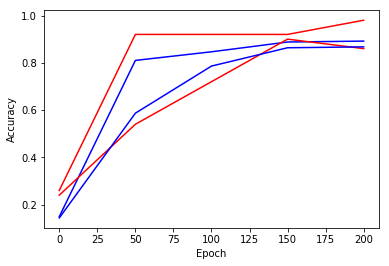

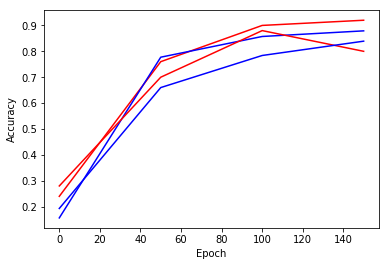

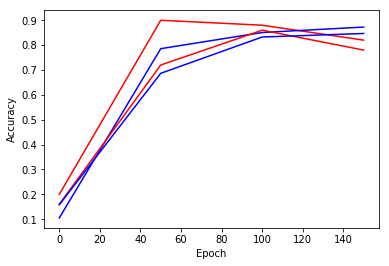

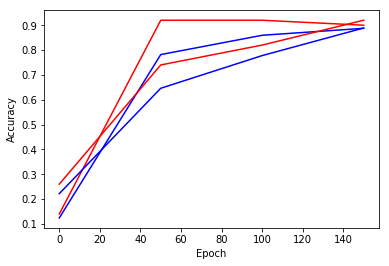

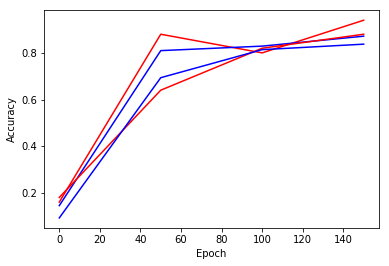

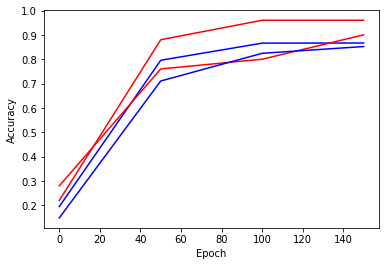

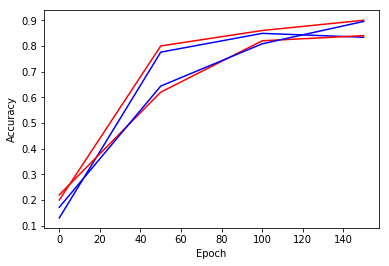

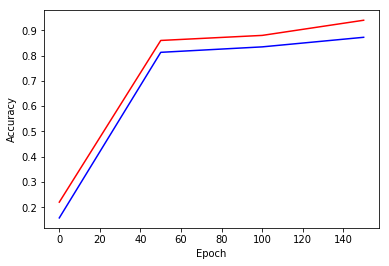

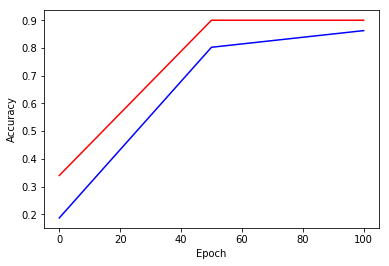

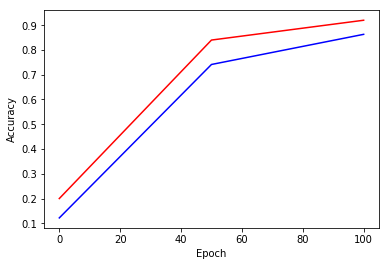

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.pyplot as plt
%matplotlib inline

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True

#Helper function to swap identities of gradients from one to the other.
def swapIdentity(gradient, newIdentity):
    return (gradient[0], newIdentity) #return new tuple with the identity replaced

def shp(x):
    return np.shape(x) 

tf.reset_default_graph()

#-----------------------Initialization---------------------------
#Hyperparameters:
theta_D = 1 #download rate
theta_U = 0.01 #Upload rate

#sz = 4 # size of network
node_sz = []
accs = []

node_sz_fully = []
accs_fully = []

for architecture in range(2): #0 = dense graph N(N-1)/2 connections, #1 = sparse graph (N connections) 
    for sz in range(20,30):
        # Variables for our  4- way network
        W1 = [tf.Variable(tf.truncated_normal([784, 500], stddev=0.1)) for i in range(sz)]
        b1 = [tf.Variable(tf.zeros([500]))                             for i in range(sz)]
        W2 = [tf.Variable(tf.truncated_normal([500, 100], stddev=0.1)) for i in range(sz)]
        b2 = [tf.Variable(tf.zeros([100]))                             for i in range(sz)]
        W3 = [tf.Variable(tf.truncated_normal([100, 10], stddev=0.1))  for i in range(sz)]
        b3 = [tf.Variable(tf.zeros([10]))                              for i in range(sz)]

        #Temporary gradient banks for communication between nodes (noise may be added in future)
        g_W1 = [None for i in range(sz)]
        g_W2 = [None for i in range(sz)]
        g_W3 = [None for i in range(sz)]
        g_b1 = [None for i in range(sz)]
        g_b2 = [None for i in range(sz)]
        g_b3 = [None for i in range(sz)]


        grad_W1 = [[None for i in range(sz)] for i in range(sz)]
        grad_W2 = [[None for i in range(sz)] for i in range(sz)]
        grad_W3 = [[None for i in range(sz)] for i in range(sz)]
        grad_b1 = [[None for i in range(sz)] for i in range(sz)]
        grad_b2 = [[None for i in range(sz)] for i in range(sz)]
        grad_b3 = [[None for i in range(sz)] for i in range(sz)]


        #hidden layers, scores, etc. *Note there is somehow a problem with saying scores = loss = [None for i in range(sz)] so I put them in seperate lines
        h1 = [None for i in range(sz)]
        h2 = [None for i in range(sz)]

        scores = [None for i in range(sz)]
        loss = [None for i in range(sz)]

        #-------------------------Define Decentralized Neural Network Structure-----------------

        # Placeholders
        X = [tf.placeholder(tf.float32, [None, 784])  for i in range(sz)]
        y = [tf.placeholder(tf.float32, [None, 10])    for i in range(sz)]


        # Deep Neural nets for 4 channels w/ loss function
        for i in range(sz):
            h1[i] = tf.nn.relu(tf.matmul(X[i],  W1[i]) + b1[i])
            h2[i] = tf.nn.relu(tf.matmul(h1[i], W2[i]) + b2[i])
            scores[i] = tf.matmul(h2[i], W3[i]) + b3[i]
            loss[i] = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=scores[i], labels=y[i]))

        # Gradient descent for 4 channels
        train_one_step = [None for i in range(sz)]
        opt =[None for i in range(sz)]

        for i in range(sz):
            opt[i] = tf.train.GradientDescentOptimizer(0.05)
            train_one_step[i] = opt[i].minimize(loss[i])



        correct_predictions = [0.0 for i in range(sz)]
        accuracy = [0.0 for i in range(sz)]

        # Accuracy indicator for 4 channels
        for i in range(sz):
            correct_predictions[i] = tf.equal(tf.argmax(scores[i], axis=1), tf.argmax(y[i], axis=1))
            accuracy[i] = tf.reduce_mean(tf.cast(correct_predictions[i], tf.float32))

        # Initialization of all decleared Tensors (above) in Tensorflow
        init = tf.global_variables_initializer()

        # Training
        sess = tf.Session()
        sess.run(init) #initalize all variables

        #Gradient "bank"

        train_acc=[0.0 for i in range(sz)]
        train_loss=[0.0 for i in range(sz)]
        test_acc = [0.0 for i in range(sz)]

        send_gradients = [[None for i in range(sz)] for i in range(sz)]

        #-----------------Build the gradients transfer graph---------------------
        for cnode in range(sz):
            #compute local gradients
            g_W1[cnode], g_W2[cnode], g_W3[cnode], g_b1[cnode], g_b2[cnode], g_b3[cnode] = opt[cnode].compute_gradients(
                    loss=loss[cnode], var_list=[W1[cnode], W2[cnode], W3[cnode], b1[cnode], b2[cnode], b3[cnode]])

            #EXperimennt around with either 1)dense, N(N-1)/2 connections, or 2)sparse graph, N connections
            #for nei in range(sz): #Dense graph
            if(architecture == 1):
                neighbors = range(sz)
            else:
                neighbors = [(cnode+1) % sz, cnode, (sz + cnode - 1) % sz]
                
            
            for nei in neighbors:
                #Distribute local gradients from current node to neighboring nodes
                grad_W1[cnode][nei] = swapIdentity(g_W1[cnode], W1[nei])
                grad_W2[cnode][nei] = swapIdentity(g_W2[cnode], W2[nei])
                grad_W3[cnode][nei] = swapIdentity(g_W3[cnode], W3[nei])
                grad_b1[cnode][nei] = swapIdentity(g_b1[cnode], b1[nei])
                grad_b2[cnode][nei] = swapIdentity(g_b2[cnode], b2[nei])
                grad_b3[cnode][nei] = swapIdentity(g_b3[cnode], b3[nei])

                send_gradients[cnode][nei] = opt[cnode].apply_gradients([
                                         grad_W1[cnode][nei], grad_W2[cnode][nei], grad_W3[cnode][nei], 
                                         grad_b1[cnode][nei], grad_b2[cnode][nei], grad_b3[cnode][nei]])

        #------------------------------Begin Training------------------------------

        #NOTE only for the first node (cnode = 0)
        x_train = []
        y_train = []

        x_test = []
        y_test = []

        #Split data into 4-ths. (50,50,50,50)

        for i in range(4200 // sz):

            for cnode in range(sz):      
                #---------download minibatch of 50 & get gradients-----------------------
                X_batch, y_batch = mnist.train.next_batch(50)

                #send gradients computed from current node to neighbors
                if(architecture == 1):
                    neighbors = range(sz)
                else:
                    neighbors = [(cnode+1) % sz, cnode, (sz + cnode - 1) % sz]
                
                for nei in neighbors:
                #for nei in range(sz):
                    sess.run(send_gradients[cnode][nei], feed_dict={X[cnode]: X_batch, y[cnode]: y_batch})



                if(i % 50 == 0):
                    train_acc[cnode] = sess.run(accuracy[cnode], feed_dict={X[cnode]: X_batch, y[cnode]: y_batch})
                    test_acc[cnode] = sess.run(accuracy[cnode], feed_dict={X[cnode]: mnist.test.images, y[cnode]: mnist.test.labels})
                    #PLOT ACCURACY OF FIRST NODE
                    if(cnode == 0):
                        x_train += [i]
                        y_train += [train_acc[cnode]]

                        x_test += [i]
                        y_test += [test_acc[cnode]]
                    print("accuracy for Node: ", cnode,  "  is: ",train_acc[cnode],  "  at epoch: ", i, " test acc: ", test_acc[cnode])

        #after done with training (for i loop), get FINAL test set accuracy for export.
        plt.figure(sz)
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.plot(x_train, y_train, 'r', x_test, y_test, 'b')

        maxacc = 0
        # Make sure to print out your accuracy on the test set at the end.
        print("Final accuracy on test set:")
        for i in range(sz):
            accy =  sess.run(accuracy[i], feed_dict={X[i]: mnist.test.images, y[i]: mnist.test.labels})
            print(i, " has accuracy: ",accy)
            maxacc = max(maxacc, accy)
        
        if(architecture == 2): #dense graph
            node_sz += [sz]
            accs += [maxacc]
        else:
            node_sz_fully += [sz]
            accs_fully += [maxacc]


#FINAL PLOT for the #of Agents (Node size) vs. accuracy (max of all agents) 
plt.figure(16)
plt.xlabel('Node size')
plt.ylabel('Accuracy')
plt.plot(node_sz, accs, 'g', node_sz_fully, accs_fully, 'r')


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
accuracy for Node:  0   is:  0.34   at epoch:  0  test acc:  0.1489
accuracy for Node:  1   is:  0.22   at epoch:  0  test acc:  0.1213
accuracy for Node:  2   is:  0.2   at epoch:  0  test acc:  0.0893
accuracy for Node:  3   is:  0.16   at epoch:  0  test acc:  0.1302
accuracy for Node:  0   is:  0.9   at epoch:  50  test acc:  0.8109
accuracy for Node:  1   is:  0.86   at epoch:  50  test acc:  0.812
accuracy for Node:  2   is:  0.86   at epoch:  50  test acc:  0.7938
accuracy for Node:  3   is:  0.82   at epoch:  50  test acc:  0.8124
accuracy for Node:  0   is:  0.9   at epoch:  100  test acc:  0.8207
accuracy for Node:  1   is:  0.9   at epoch:  100  test acc:  0.8556
accuracy for Node:  2   is:  0.94   at epoch:  100  test acc:  0.8614
accuracy for Node:  3   is:  0.92   at epoch:  100  t

accuracy for Node:  0   is:  1.0   at epoch:  300  test acc:  0.905
accuracy for Node:  1   is:  0.94   at epoch:  300  test acc:  0.9097
accuracy for Node:  2   is:  0.92   at epoch:  300  test acc:  0.899
accuracy for Node:  3   is:  0.94   at epoch:  300  test acc:  0.8841
accuracy for Node:  4   is:  0.98   at epoch:  300  test acc:  0.9018
accuracy for Node:  5   is:  0.98   at epoch:  300  test acc:  0.91
Final accuracy on test set:
0  has accuracy:  0.9042
1  has accuracy:  0.9111
2  has accuracy:  0.9001
3  has accuracy:  0.8957
4  has accuracy:  0.9085
5  has accuracy:  0.906
accuracy for Node:  0   is:  0.18   at epoch:  0  test acc:  0.1248
accuracy for Node:  1   is:  0.24   at epoch:  0  test acc:  0.1488
accuracy for Node:  2   is:  0.34   at epoch:  0  test acc:  0.1186
accuracy for Node:  3   is:  0.16   at epoch:  0  test acc:  0.1275
accuracy for Node:  4   is:  0.2   at epoch:  0  test acc:  0.1551
accuracy for Node:  5   is:  0.18   at epoch:  0  test acc:  0.1623
a

accuracy for Node:  0   is:  0.96   at epoch:  150  test acc:  0.8607
accuracy for Node:  1   is:  0.96   at epoch:  150  test acc:  0.8723
accuracy for Node:  2   is:  0.92   at epoch:  150  test acc:  0.8864
accuracy for Node:  3   is:  0.92   at epoch:  150  test acc:  0.8787
accuracy for Node:  4   is:  0.9   at epoch:  150  test acc:  0.8666
accuracy for Node:  5   is:  0.9   at epoch:  150  test acc:  0.8871
accuracy for Node:  6   is:  0.88   at epoch:  150  test acc:  0.8773
accuracy for Node:  7   is:  0.94   at epoch:  150  test acc:  0.866
accuracy for Node:  8   is:  0.9   at epoch:  150  test acc:  0.8803
accuracy for Node:  0   is:  0.94   at epoch:  200  test acc:  0.8928
accuracy for Node:  1   is:  0.96   at epoch:  200  test acc:  0.8928
accuracy for Node:  2   is:  0.86   at epoch:  200  test acc:  0.8961
accuracy for Node:  3   is:  0.96   at epoch:  200  test acc:  0.8965
accuracy for Node:  4   is:  0.96   at epoch:  200  test acc:  0.8908
accuracy for Node:  5   

accuracy for Node:  6   is:  0.2   at epoch:  0  test acc:  0.0786
accuracy for Node:  7   is:  0.1   at epoch:  0  test acc:  0.0976
accuracy for Node:  8   is:  0.22   at epoch:  0  test acc:  0.1204
accuracy for Node:  9   is:  0.26   at epoch:  0  test acc:  0.1482
accuracy for Node:  10   is:  0.14   at epoch:  0  test acc:  0.1102
accuracy for Node:  11   is:  0.18   at epoch:  0  test acc:  0.0959
accuracy for Node:  0   is:  0.84   at epoch:  50  test acc:  0.7885
accuracy for Node:  1   is:  0.84   at epoch:  50  test acc:  0.7961
accuracy for Node:  2   is:  0.86   at epoch:  50  test acc:  0.8184
accuracy for Node:  3   is:  0.7   at epoch:  50  test acc:  0.7405
accuracy for Node:  4   is:  0.86   at epoch:  50  test acc:  0.7806
accuracy for Node:  5   is:  0.8   at epoch:  50  test acc:  0.7978
accuracy for Node:  6   is:  0.86   at epoch:  50  test acc:  0.8057
accuracy for Node:  7   is:  0.9   at epoch:  50  test acc:  0.7887
accuracy for Node:  8   is:  0.9   at epoch

accuracy for Node:  0   is:  0.9   at epoch:  100  test acc:  0.8468
accuracy for Node:  1   is:  0.86   at epoch:  100  test acc:  0.8426
accuracy for Node:  2   is:  0.88   at epoch:  100  test acc:  0.8333
accuracy for Node:  3   is:  0.96   at epoch:  100  test acc:  0.8493
accuracy for Node:  4   is:  0.86   at epoch:  100  test acc:  0.8611
accuracy for Node:  5   is:  0.92   at epoch:  100  test acc:  0.8288
accuracy for Node:  6   is:  0.92   at epoch:  100  test acc:  0.8575
accuracy for Node:  7   is:  0.88   at epoch:  100  test acc:  0.8637
accuracy for Node:  8   is:  0.96   at epoch:  100  test acc:  0.8452
accuracy for Node:  9   is:  0.84   at epoch:  100  test acc:  0.8607
accuracy for Node:  10   is:  0.9   at epoch:  100  test acc:  0.869
accuracy for Node:  11   is:  0.86   at epoch:  100  test acc:  0.8595
accuracy for Node:  12   is:  0.94   at epoch:  100  test acc:  0.8576
accuracy for Node:  13   is:  0.92   at epoch:  100  test acc:  0.8653
Final accuracy on t

accuracy for Node:  0   is:  0.86   at epoch:  100  test acc:  0.8441
accuracy for Node:  1   is:  0.86   at epoch:  100  test acc:  0.8386
accuracy for Node:  2   is:  0.9   at epoch:  100  test acc:  0.8321
accuracy for Node:  3   is:  0.88   at epoch:  100  test acc:  0.8363
accuracy for Node:  4   is:  0.98   at epoch:  100  test acc:  0.843
accuracy for Node:  0   is:  0.86   at epoch:  150  test acc:  0.8885
accuracy for Node:  1   is:  0.88   at epoch:  150  test acc:  0.887
accuracy for Node:  2   is:  0.98   at epoch:  150  test acc:  0.877
accuracy for Node:  3   is:  0.9   at epoch:  150  test acc:  0.8489
accuracy for Node:  4   is:  0.88   at epoch:  150  test acc:  0.8562
accuracy for Node:  0   is:  0.86   at epoch:  200  test acc:  0.8625
accuracy for Node:  1   is:  0.94   at epoch:  200  test acc:  0.8517
accuracy for Node:  2   is:  0.92   at epoch:  200  test acc:  0.8653
accuracy for Node:  3   is:  0.9   at epoch:  200  test acc:  0.897
accuracy for Node:  4   is:

Final accuracy on test set:
0  has accuracy:  0.9029
1  has accuracy:  0.9053
2  has accuracy:  0.9085
3  has accuracy:  0.906
4  has accuracy:  0.9074
5  has accuracy:  0.8936
6  has accuracy:  0.8538
accuracy for Node:  0   is:  0.24   at epoch:  0  test acc:  0.1728
accuracy for Node:  1   is:  0.16   at epoch:  0  test acc:  0.0964
accuracy for Node:  2   is:  0.2   at epoch:  0  test acc:  0.1678
accuracy for Node:  3   is:  0.1   at epoch:  0  test acc:  0.0794
accuracy for Node:  4   is:  0.22   at epoch:  0  test acc:  0.1158
accuracy for Node:  5   is:  0.2   at epoch:  0  test acc:  0.1048
accuracy for Node:  6   is:  0.14   at epoch:  0  test acc:  0.1413
accuracy for Node:  7   is:  0.32   at epoch:  0  test acc:  0.1527
accuracy for Node:  0   is:  0.74   at epoch:  50  test acc:  0.6853
accuracy for Node:  1   is:  0.78   at epoch:  50  test acc:  0.6897
accuracy for Node:  2   is:  0.72   at epoch:  50  test acc:  0.7166
accuracy for Node:  3   is:  0.72   at epoch:  50 

accuracy for Node:  0   is:  0.92   at epoch:  150  test acc:  0.8558
accuracy for Node:  1   is:  0.84   at epoch:  150  test acc:  0.8656
accuracy for Node:  2   is:  0.9   at epoch:  150  test acc:  0.8612
accuracy for Node:  3   is:  0.9   at epoch:  150  test acc:  0.8625
accuracy for Node:  4   is:  0.9   at epoch:  150  test acc:  0.8719
accuracy for Node:  5   is:  0.92   at epoch:  150  test acc:  0.8825
accuracy for Node:  6   is:  0.92   at epoch:  150  test acc:  0.8865
accuracy for Node:  7   is:  0.88   at epoch:  150  test acc:  0.8577
accuracy for Node:  8   is:  0.92   at epoch:  150  test acc:  0.8859
accuracy for Node:  9   is:  0.78   at epoch:  150  test acc:  0.6553
Final accuracy on test set:
0  has accuracy:  0.8758
1  has accuracy:  0.8787
2  has accuracy:  0.8812
3  has accuracy:  0.8841
4  has accuracy:  0.884
5  has accuracy:  0.8845
6  has accuracy:  0.8825
7  has accuracy:  0.8775
8  has accuracy:  0.8683
9  has accuracy:  0.8189
accuracy for Node:  0   is

/home/patrick/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Final accuracy on test set:
0  has accuracy:  0.878
1  has accuracy:  0.8796
2  has accuracy:  0.8931
3  has accuracy:  0.8863
4  has accuracy:  0.8876
5  has accuracy:  0.8918
6  has accuracy:  0.892
7  has accuracy:  0.9051
8  has accuracy:  0.8997
9  has accuracy:  0.8813
10  has accuracy:  0.8839
11  has accuracy:  0.8769
accuracy for Node:  0   is:  0.16   at epoch:  0  test acc:  0.1606
accuracy for Node:  1   is:  0.24   at epoch:  0  test acc:  0.1567
accuracy for Node:  2   is:  0.22   at epoch:  0  test acc:  0.1523
accuracy for Node:  3   is:  0.36   at epoch:  0  test acc:  0.1917
accuracy for Node:  4   is:  0.26   at epoch:  0  test acc:  0.1325
accuracy for Node:  5   is:  0.12   at epoch:  0  test acc:  0.1079
accuracy for Node:  6   is:  0.22   at epoch:  0  test acc:  0.1368
accuracy for Node:  7   is:  0.16   at epoch:  0  test acc:  0.1286
accuracy for Node:  8   is:  0.06   at epoch:  0  test acc:  0.0764
accuracy for Node:  9   is:  0.14   at epoch:  0  test acc: 

accuracy for Node:  10   is:  0.22   at epoch:  0  test acc:  0.1479
accuracy for Node:  11   is:  0.18   at epoch:  0  test acc:  0.1732
accuracy for Node:  12   is:  0.2   at epoch:  0  test acc:  0.1544
accuracy for Node:  13   is:  0.16   at epoch:  0  test acc:  0.0893
accuracy for Node:  14   is:  0.16   at epoch:  0  test acc:  0.1492
accuracy for Node:  0   is:  0.78   at epoch:  50  test acc:  0.6642
accuracy for Node:  1   is:  0.76   at epoch:  50  test acc:  0.6872
accuracy for Node:  2   is:  0.7   at epoch:  50  test acc:  0.6777
accuracy for Node:  3   is:  0.68   at epoch:  50  test acc:  0.6808
accuracy for Node:  4   is:  0.78   at epoch:  50  test acc:  0.6907
accuracy for Node:  5   is:  0.72   at epoch:  50  test acc:  0.6679
accuracy for Node:  6   is:  0.72   at epoch:  50  test acc:  0.7533
accuracy for Node:  7   is:  0.74   at epoch:  50  test acc:  0.7562
accuracy for Node:  8   is:  0.7   at epoch:  50  test acc:  0.7318
accuracy for Node:  9   is:  0.86   a

Final accuracy on test set:
0  has accuracy:  0.906
1  has accuracy:  0.9176
2  has accuracy:  0.9196
3  has accuracy:  0.9195
4  has accuracy:  0.9181
accuracy for Node:  0   is:  0.12   at epoch:  0  test acc:  0.103
accuracy for Node:  1   is:  0.26   at epoch:  0  test acc:  0.1739
accuracy for Node:  2   is:  0.26   at epoch:  0  test acc:  0.1409
accuracy for Node:  3   is:  0.08   at epoch:  0  test acc:  0.1061
accuracy for Node:  4   is:  0.08   at epoch:  0  test acc:  0.08
accuracy for Node:  5   is:  0.26   at epoch:  0  test acc:  0.1238
accuracy for Node:  0   is:  0.86   at epoch:  50  test acc:  0.7759
accuracy for Node:  1   is:  0.88   at epoch:  50  test acc:  0.8271
accuracy for Node:  2   is:  0.88   at epoch:  50  test acc:  0.8108
accuracy for Node:  3   is:  0.92   at epoch:  50  test acc:  0.7881
accuracy for Node:  4   is:  0.9   at epoch:  50  test acc:  0.7981
accuracy for Node:  5   is:  0.92   at epoch:  50  test acc:  0.7539
accuracy for Node:  0   is:  0

accuracy for Node:  0   is:  0.94   at epoch:  200  test acc:  0.8945
accuracy for Node:  1   is:  0.94   at epoch:  200  test acc:  0.8899
accuracy for Node:  2   is:  0.96   at epoch:  200  test acc:  0.8778
accuracy for Node:  3   is:  0.96   at epoch:  200  test acc:  0.8797
accuracy for Node:  4   is:  0.94   at epoch:  200  test acc:  0.8918
accuracy for Node:  5   is:  0.96   at epoch:  200  test acc:  0.8888
accuracy for Node:  6   is:  0.94   at epoch:  200  test acc:  0.8667
accuracy for Node:  7   is:  0.92   at epoch:  200  test acc:  0.8977
Final accuracy on test set:
0  has accuracy:  0.8946
1  has accuracy:  0.8976
2  has accuracy:  0.8857
3  has accuracy:  0.8954
4  has accuracy:  0.8905
5  has accuracy:  0.905
6  has accuracy:  0.893
7  has accuracy:  0.8981
accuracy for Node:  0   is:  0.16   at epoch:  0  test acc:  0.1212
accuracy for Node:  1   is:  0.34   at epoch:  0  test acc:  0.1586
accuracy for Node:  2   is:  0.22   at epoch:  0  test acc:  0.1624
accuracy f

accuracy for Node:  0   is:  0.9   at epoch:  100  test acc:  0.8613
accuracy for Node:  1   is:  0.92   at epoch:  100  test acc:  0.862
accuracy for Node:  2   is:  0.9   at epoch:  100  test acc:  0.8619
accuracy for Node:  3   is:  0.84   at epoch:  100  test acc:  0.855
accuracy for Node:  4   is:  0.94   at epoch:  100  test acc:  0.8649
accuracy for Node:  5   is:  0.94   at epoch:  100  test acc:  0.8636
accuracy for Node:  6   is:  0.86   at epoch:  100  test acc:  0.8323
accuracy for Node:  7   is:  0.9   at epoch:  100  test acc:  0.8589
accuracy for Node:  8   is:  0.86   at epoch:  100  test acc:  0.8568
accuracy for Node:  9   is:  0.94   at epoch:  100  test acc:  0.8625
accuracy for Node:  10   is:  0.96   at epoch:  100  test acc:  0.8419
accuracy for Node:  0   is:  0.88   at epoch:  150  test acc:  0.8806
accuracy for Node:  1   is:  0.92   at epoch:  150  test acc:  0.866
accuracy for Node:  2   is:  0.94   at epoch:  150  test acc:  0.8679
accuracy for Node:  3   i

Final accuracy on test set:
0  has accuracy:  0.8763
1  has accuracy:  0.8823
2  has accuracy:  0.883
3  has accuracy:  0.8764
4  has accuracy:  0.852
5  has accuracy:  0.886
6  has accuracy:  0.8481
7  has accuracy:  0.8755
8  has accuracy:  0.8878
9  has accuracy:  0.8817
10  has accuracy:  0.8683
11  has accuracy:  0.8661
12  has accuracy:  0.8735
accuracy for Node:  0   is:  0.24   at epoch:  0  test acc:  0.1647
accuracy for Node:  1   is:  0.28   at epoch:  0  test acc:  0.1331
accuracy for Node:  2   is:  0.2   at epoch:  0  test acc:  0.1463
accuracy for Node:  3   is:  0.32   at epoch:  0  test acc:  0.1684
accuracy for Node:  4   is:  0.28   at epoch:  0  test acc:  0.1236
accuracy for Node:  5   is:  0.14   at epoch:  0  test acc:  0.0973
accuracy for Node:  6   is:  0.2   at epoch:  0  test acc:  0.1135
accuracy for Node:  7   is:  0.14   at epoch:  0  test acc:  0.1287
accuracy for Node:  8   is:  0.14   at epoch:  0  test acc:  0.1369
accuracy for Node:  9   is:  0.26   a

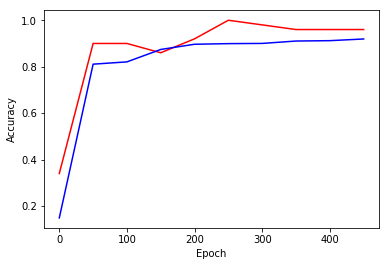

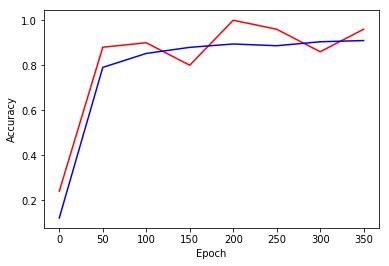

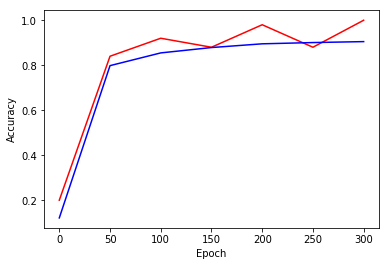

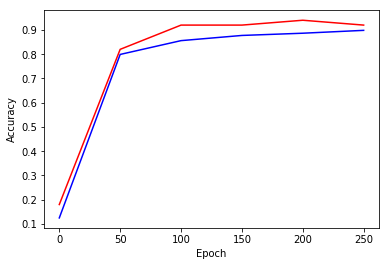

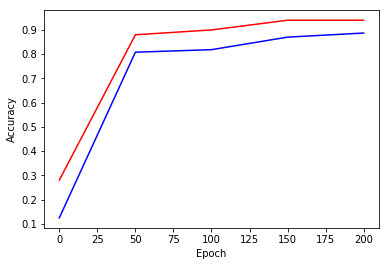

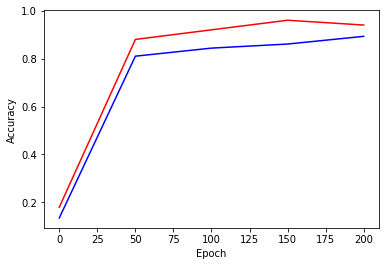

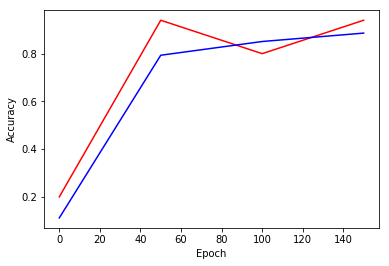

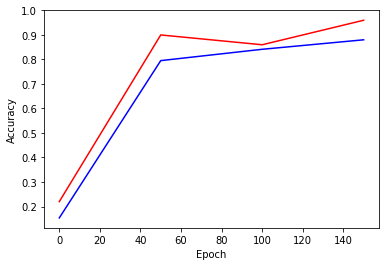

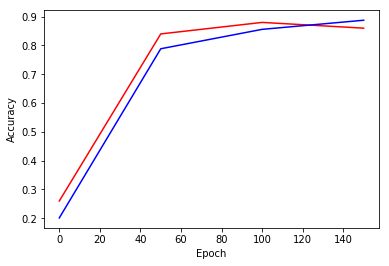

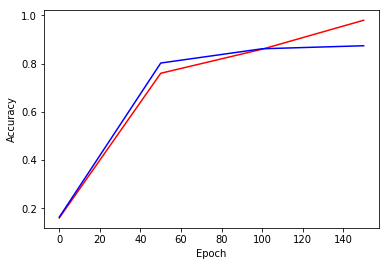

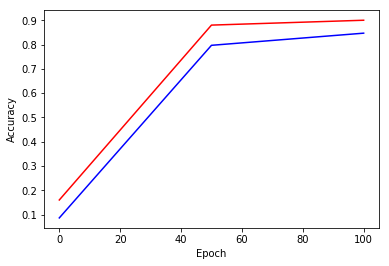

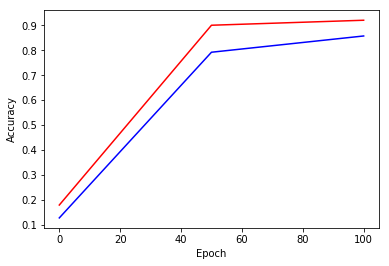

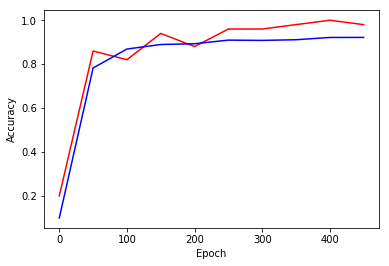

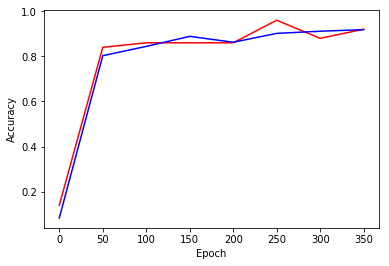

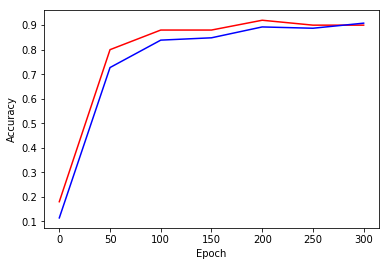

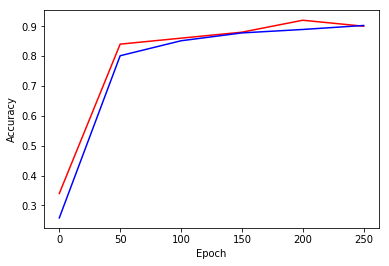

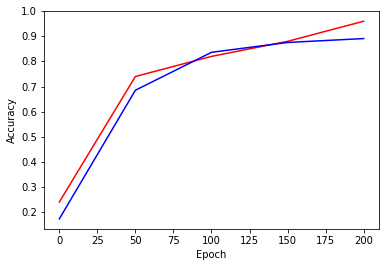

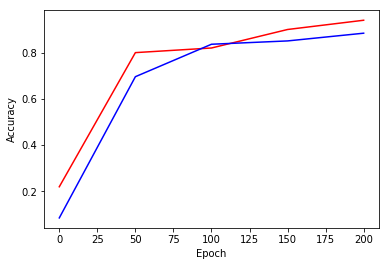

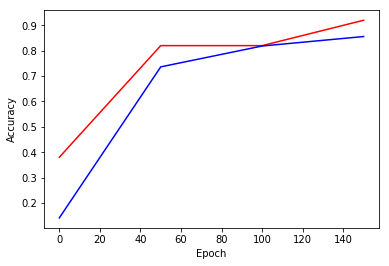

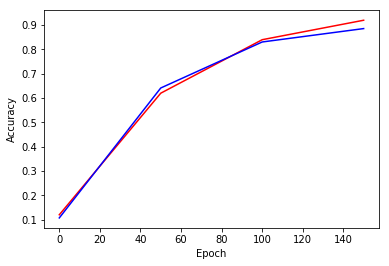

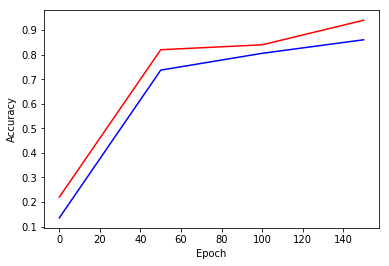

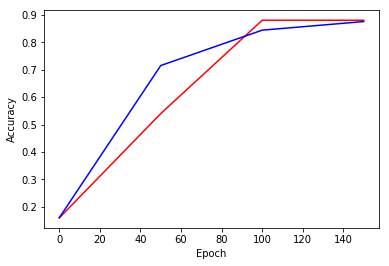

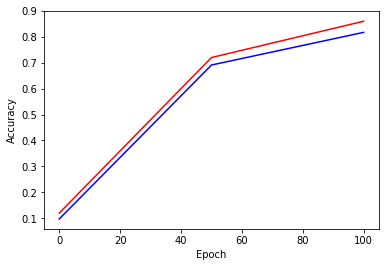

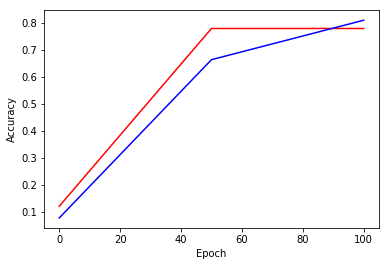

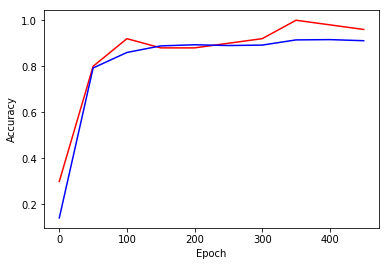

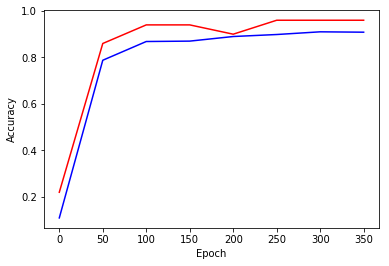

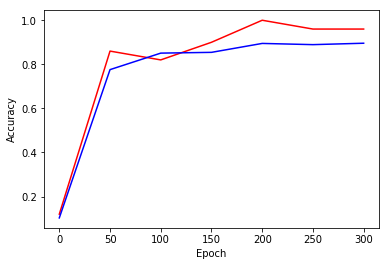

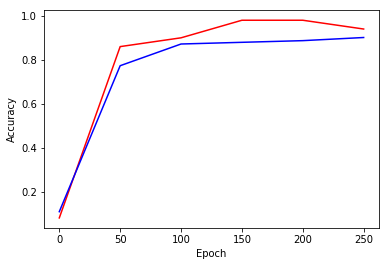

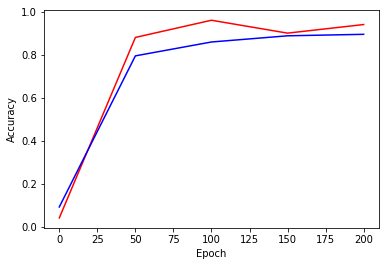

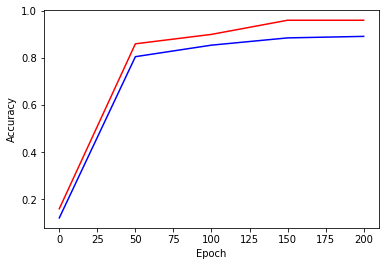

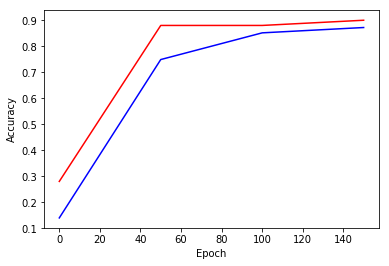

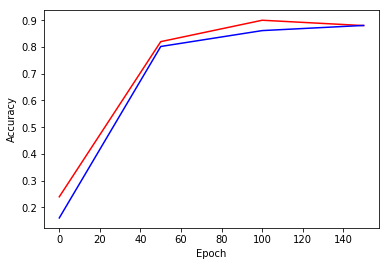

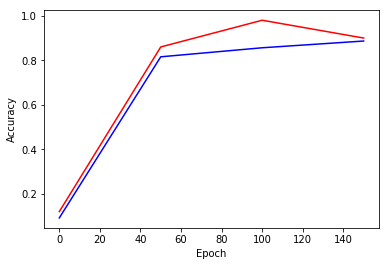

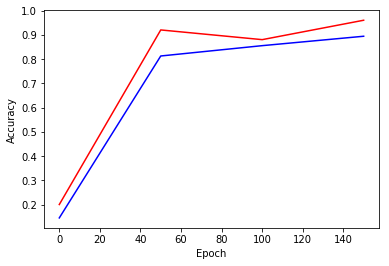

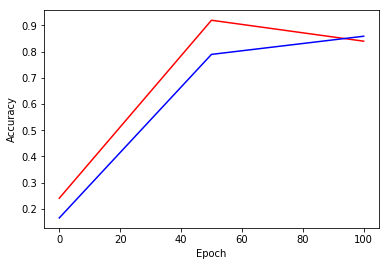

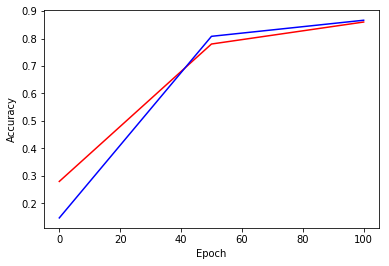

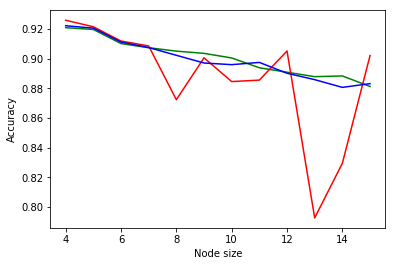

In [6]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.pyplot as plt
%matplotlib inline

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True

#Helper function to swap identities of gradients from one to the other.
def swapIdentity(gradient, newIdentity):
    return (gradient[0], newIdentity) #return new tuple with the identity replaced

def shp(x):
    return np.shape(x) 

#-----------------------Initialization---------------------------
#Hyperparameters:
theta_D = 1 #download rate
theta_U = 0.01 #Upload rate

#sz = 4 # size of network
node_sz = []
accs = []

node_sz_fully = []
accs_fully = []

node_sz_indiv = []
accs_indiv = []
plots = 0

for architecture in range(3): #0 = dense graph N(N-1)/2 connections, #1 = sparse graph (N connections), #3 = independent 
    for sz in range(4,16):
        
        tf.reset_default_graph()

        # Variables for our  4- way network
        W1 = [tf.Variable(tf.truncated_normal([784, 500], stddev=0.1)) for i in range(sz)]
        b1 = [tf.Variable(tf.zeros([500]))                             for i in range(sz)]
        W2 = [tf.Variable(tf.truncated_normal([500, 100], stddev=0.1)) for i in range(sz)]
        b2 = [tf.Variable(tf.zeros([100]))                             for i in range(sz)]
        W3 = [tf.Variable(tf.truncated_normal([100, 10], stddev=0.1))  for i in range(sz)]
        b3 = [tf.Variable(tf.zeros([10]))                              for i in range(sz)]

        #Temporary gradient banks for communication between nodes (noise may be added in future)
        g_W1 = [None for i in range(sz)]
        g_W2 = [None for i in range(sz)]
        g_W3 = [None for i in range(sz)]
        g_b1 = [None for i in range(sz)]
        g_b2 = [None for i in range(sz)]
        g_b3 = [None for i in range(sz)]


        grad_W1 = [[None for i in range(sz)] for i in range(sz)]
        grad_W2 = [[None for i in range(sz)] for i in range(sz)]
        grad_W3 = [[None for i in range(sz)] for i in range(sz)]
        grad_b1 = [[None for i in range(sz)] for i in range(sz)]
        grad_b2 = [[None for i in range(sz)] for i in range(sz)]
        grad_b3 = [[None for i in range(sz)] for i in range(sz)]


        #hidden layers, scores, etc. *Note there is somehow a problem with saying scores = loss = [None for i in range(sz)] so I put them in seperate lines
        h1 = [None for i in range(sz)]
        h2 = [None for i in range(sz)]

        scores = [None for i in range(sz)]
        loss = [None for i in range(sz)]

        #-------------------------Define Decentralized Neural Network Structure-----------------

        # Placeholders
        X = [tf.placeholder(tf.float32, [None, 784])  for i in range(sz)]
        y = [tf.placeholder(tf.float32, [None, 10])    for i in range(sz)]


        # Deep Neural nets for 4 channels w/ loss function
        for i in range(sz):
            h1[i] = tf.nn.relu(tf.matmul(X[i],  W1[i]) + b1[i])
            h2[i] = tf.nn.relu(tf.matmul(h1[i], W2[i]) + b2[i])
            scores[i] = tf.matmul(h2[i], W3[i]) + b3[i]
            loss[i] = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=scores[i], labels=y[i]))

        # Gradient descent for 4 channels
        train_one_step = [None for i in range(sz)]
        opt =[None for i in range(sz)]

        for i in range(sz):
            opt[i] = tf.train.GradientDescentOptimizer(0.05)
            train_one_step[i] = opt[i].minimize(loss[i])



        correct_predictions = [0.0 for i in range(sz)]
        accuracy = [0.0 for i in range(sz)]

        # Accuracy indicator for 4 channels
        for i in range(sz):
            correct_predictions[i] = tf.equal(tf.argmax(scores[i], axis=1), tf.argmax(y[i], axis=1))
            accuracy[i] = tf.reduce_mean(tf.cast(correct_predictions[i], tf.float32))

        # Initialization of all decleared Tensors (above) in Tensorflow
        init = tf.global_variables_initializer()

        # Training
        sess = tf.Session()
        sess.run(init) #initalize all variables

        #Gradient "bank"

        train_acc=[0.0 for i in range(sz)]
        train_loss=[0.0 for i in range(sz)]
        test_acc = [0.0 for i in range(sz)]

        send_gradients = [[None for i in range(sz)] for i in range(sz)]

        #-----------------Build the gradients transfer graph---------------------
        for cnode in range(sz):
            #compute local gradients
            g_W1[cnode], g_W2[cnode], g_W3[cnode], g_b1[cnode], g_b2[cnode], g_b3[cnode] = opt[cnode].compute_gradients(
                    loss=loss[cnode], var_list=[W1[cnode], W2[cnode], W3[cnode], b1[cnode], b2[cnode], b3[cnode]])

            #EXperimennt around with either 1)dense, N(N-1)/2 connections, or 2)sparse graph, N connections
            #for nei in range(sz): #Dense graph
            if(architecture == 1):
                neighbors = range(sz)
            elif(architecture == 2):
                neighbors = [(cnode+1) % sz, cnode, (sz + cnode - 1) % sz]
            else:
                neighbors = [cnode]
            
            for nei in neighbors:
                #Distribute local gradients from current node to neighboring nodes
                grad_W1[cnode][nei] = swapIdentity(g_W1[cnode], W1[nei])
                grad_W2[cnode][nei] = swapIdentity(g_W2[cnode], W2[nei])
                grad_W3[cnode][nei] = swapIdentity(g_W3[cnode], W3[nei])
                grad_b1[cnode][nei] = swapIdentity(g_b1[cnode], b1[nei])
                grad_b2[cnode][nei] = swapIdentity(g_b2[cnode], b2[nei])
                grad_b3[cnode][nei] = swapIdentity(g_b3[cnode], b3[nei])
                #is this Part Working? Like, is it REALLLY sharing the same gradients as with other nodes??
                send_gradients[cnode][nei] = opt[cnode].apply_gradients([
                                         grad_W1[cnode][nei], grad_W2[cnode][nei], grad_W3[cnode][nei], 
                                         grad_b1[cnode][nei], grad_b2[cnode][nei], grad_b3[cnode][nei]])

        #------------------------------Begin Training------------------------------

        #NOTE only for the first node (cnode = 0)
        x_train = []
        y_train = []

        x_test = []
        y_test = []

        #Split data into 4-ths. (50,50,50,50)

        for i in range(2000 // sz):

            for cnode in range(sz):      
                #---------download minibatch of 50 & get gradients-----------------------
                X_batch, y_batch = mnist.train.next_batch(50)

                #send gradients computed from current node to neighbors
                if(architecture == 1):
                    neighbors = range(sz)
                elif(architecture == 2):
                    neighbors = [(cnode+1) % sz, cnode, (sz + cnode - 1) % sz]
                else: #arch = 0: indiviaul
                    neighbors = [cnode]
                    
                for nei in neighbors:
                #for nei in range(sz):
                    sess.run(send_gradients[cnode][nei], feed_dict={X[cnode]: X_batch, y[cnode]: y_batch})



                if(i % 50 == 0):
                    train_acc[cnode] = sess.run(accuracy[cnode], feed_dict={X[cnode]: X_batch, y[cnode]: y_batch})
                    test_acc[cnode] = sess.run(accuracy[cnode], feed_dict={X[cnode]: mnist.test.images, y[cnode]: mnist.test.labels})
                    #PLOT ACCURACY OF FIRST NODE
                    if(cnode == 0):
                        x_train += [i]
                        y_train += [train_acc[cnode]]

                        x_test += [i]
                        y_test += [test_acc[cnode]]
                    print("accuracy for Node: ", cnode,  "  is: ",train_acc[cnode],  "  at epoch: ", i, " test acc: ", test_acc[cnode])

        #after done with training (for i loop), get FINAL test set accuracy for export.
        plots+=1
        plt.figure(plots)
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.plot(x_train, y_train, 'r', x_test, y_test, 'b')

        maxacc = 0
        # Make sure to print out your accuracy on the test set at the end.
        print("Final accuracy on test set:")
        for i in range(sz):
            accy =  sess.run(accuracy[i], feed_dict={X[i]: mnist.test.images, y[i]: mnist.test.labels})
            print(i, " has accuracy: ",accy)
            maxacc = max(maxacc, accy)
        
        
        if(architecture == 1): #arch = 1: fully
            node_sz_fully += [sz]
            accs_fully += [maxacc]
        elif(architecture == 2): #arch = 2: sparse graph
            node_sz += [sz]
            accs += [maxacc]
        else: #arch = 0: individual
            node_sz_indiv += [sz]
            accs_indiv += [maxacc]

#FINAL PLOT for the #of Agents (Node size) vs. accuracy (max of all agents) 
plt.figure(plots+1)
plt.xlabel('Node size')
plt.ylabel('Accuracy')
#GREEN: sparse results RED: dense results BLUE: individual results
plt.plot(node_sz, accs, 'g', node_sz_fully, accs_fully, 'r', node_sz_indiv, accs_indiv, 'b')


**Problem arisen**

How do you make good accuracy even with less datapoint? 
Try Mixup augmentation. Also should each node recieve weaker gradients for another node's datasets?? Dunno?

In [22]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.pyplot as plt
%matplotlib inline

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True

#Helper function to swap identities of gradients from one to the other.
def swapIdentity(gradient, newIdentity):
    return (gradient[0], newIdentity) #return new tuple with the identity replaced

def shp(x):
    return np.shape(x) 

#-----------------------Initialization---------------------------
#Hyperparameters:
theta_D = 1 #download rate
theta_U = 0.01 #Upload rate

#sz = 4 # size of network
node_sz = []
accs = []

node_sz_fully = []
accs_fully = []

node_sz_indiv = []
accs_indiv = []
plots = 0

architecture = 0 #0 = individual 1=dense 2=sparse
sz = 13
        
tf.reset_default_graph()

# Variables for our  4- way network
W1 = [tf.Variable(tf.truncated_normal([784, 500], stddev=0.1)) for i in range(sz)]
b1 = [tf.Variable(tf.zeros([500]))                             for i in range(sz)]
W2 = [tf.Variable(tf.truncated_normal([500, 100], stddev=0.1)) for i in range(sz)]
b2 = [tf.Variable(tf.zeros([100]))                             for i in range(sz)]
W3 = [tf.Variable(tf.truncated_normal([100, 10], stddev=0.1))  for i in range(sz)]
b3 = [tf.Variable(tf.zeros([10]))                              for i in range(sz)]

#Temporary gradient banks for communication between nodes (noise may be added in future)
g_W1 = [None for i in range(sz)]
g_W2 = [None for i in range(sz)]
g_W3 = [None for i in range(sz)]
g_b1 = [None for i in range(sz)]
g_b2 = [None for i in range(sz)]
g_b3 = [None for i in range(sz)]


grad_W1 = [[None for i in range(sz)] for i in range(sz)]
grad_W2 = [[None for i in range(sz)] for i in range(sz)]
grad_W3 = [[None for i in range(sz)] for i in range(sz)]
grad_b1 = [[None for i in range(sz)] for i in range(sz)]
grad_b2 = [[None for i in range(sz)] for i in range(sz)]
grad_b3 = [[None for i in range(sz)] for i in range(sz)]


#hidden layers, scores, etc. *Note there is somehow a problem with saying scores = loss = [None for i in range(sz)] so I put them in seperate lines
h1 = [None for i in range(sz)]
h2 = [None for i in range(sz)]

scores = [None for i in range(sz)]
loss = [None for i in range(sz)]

#-------------------------Define Decentralized Neural Network Structure-----------------

# Placeholders
X = [tf.placeholder(tf.float32, [None, 784])  for i in range(sz)]
y = [tf.placeholder(tf.float32, [None, 10])    for i in range(sz)]


# Deep Neural nets for 4 channels w/ loss function
for i in range(sz):
    h1[i] = tf.nn.relu(tf.matmul(X[i],  W1[i]) + b1[i])
    h2[i] = tf.nn.relu(tf.matmul(h1[i], W2[i]) + b2[i])
    scores[i] = tf.matmul(h2[i], W3[i]) + b3[i]
    loss[i] = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=scores[i], labels=y[i]))

# Gradient descent for 4 channels
train_one_step = [None for i in range(sz)]
opt =[None for i in range(sz)]

for i in range(sz):
    opt[i] = tf.train.GradientDescentOptimizer(0.05)
    train_one_step[i] = opt[i].minimize(loss[i])



correct_predictions = [0.0 for i in range(sz)]
accuracy = [0.0 for i in range(sz)]

# Accuracy indicator for 4 channels
for i in range(sz):
    correct_predictions[i] = tf.equal(tf.argmax(scores[i], axis=1), tf.argmax(y[i], axis=1))
    accuracy[i] = tf.reduce_mean(tf.cast(correct_predictions[i], tf.float32))

# Initialization of all decleared Tensors (above) in Tensorflow
init = tf.global_variables_initializer()

# Training
sess = tf.Session()
sess.run(init) #initalize all variables

#Gradient "bank"

train_acc=[0.0 for i in range(sz)]
train_loss=[0.0 for i in range(sz)]
test_acc = [0.0 for i in range(sz)]

send_gradients = [[None for i in range(sz)] for i in range(sz)]

#-----------------Build the gradients transfer graph---------------------
for cnode in range(sz):
    #compute local gradients
    g_W1[cnode], g_W2[cnode], g_W3[cnode], g_b1[cnode], g_b2[cnode], g_b3[cnode] = opt[cnode].compute_gradients(
            loss=loss[cnode], var_list=[W1[cnode], W2[cnode], W3[cnode], b1[cnode], b2[cnode], b3[cnode]])

    #EXperimennt around with either 1)dense, N(N-1)/2 connections, or 2)sparse graph, N connections
    #for nei in range(sz): #Dense graph
    if(architecture == 1):
        neighbors = range(sz)
    elif(architecture == 2):
        neighbors = [(cnode+1) % sz, cnode, (sz + cnode - 1) % sz]
    else:
        neighbors = [cnode]

    for nei in neighbors:
        #Distribute local gradients from current node to neighboring nodes
        grad_W1[cnode][nei] = swapIdentity(g_W1[cnode], W1[nei])
        grad_W2[cnode][nei] = swapIdentity(g_W2[cnode], W2[nei])
        grad_W3[cnode][nei] = swapIdentity(g_W3[cnode], W3[nei])
        grad_b1[cnode][nei] = swapIdentity(g_b1[cnode], b1[nei])
        grad_b2[cnode][nei] = swapIdentity(g_b2[cnode], b2[nei])
        grad_b3[cnode][nei] = swapIdentity(g_b3[cnode], b3[nei])

        send_gradients[cnode][nei] = opt[cnode].apply_gradients([
                                 grad_W1[cnode][nei], grad_W2[cnode][nei], grad_W3[cnode][nei], 
                                 grad_b1[cnode][nei], grad_b2[cnode][nei], grad_b3[cnode][nei]])

#------------------------------Begin Training------------------------------

#NOTE only for the first node (cnode = 0)
x_train = []
y_train = []

x_test = []
y_test = []

#Split data into 4-ths. (50,50,50,50)

for i in range(4000 // sz):

    for cnode in range(sz):      
        #---------download minibatch of 50 & get gradients-----------------------
        X_batch, y_batch = mnist.train.next_batch(50)

        #send gradients computed from current node to neighbors
        if(architecture == 1):
            neighbors = range(sz)
        elif(architecture == 2):
            neighbors = [(cnode+1) % sz, cnode, (sz + cnode - 1) % sz]
        else: #arch = 0: indiviaul
            neighbors = [cnode]
        
        #Replace this with a ONE-CALL?
        
        '''
        for nei in neighbors:
        #for nei in range(sz):
             sess.run(send_gradients[cnode][nei], feed_dict={X[cnode]: X_batch, y[cnode]: y_batch})
        '''


        if(i % 50 == 0):
            train_acc[cnode] = sess.run(accuracy[cnode], feed_dict={X[cnode]: X_batch, y[cnode]: y_batch})
            test_acc[cnode] = sess.run(accuracy[cnode], feed_dict={X[cnode]: mnist.test.images, y[cnode]: mnist.test.labels})
            #PLOT ACCURACY OF FIRST NODE
            if(cnode == 0):
                x_train += [i]
                y_train += [train_acc[cnode]]

                x_test += [i]
                y_test += [test_acc[cnode]]
            print("accuracy for Node: ", cnode,  "  is: ",train_acc[cnode],  "  at epoch: ", i, " test acc: ", test_acc[cnode])

#after done with training (for i loop), get FINAL test set accuracy for export.
'''
plots+=1
plt.figure(plots)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(x_train, y_train, 'r', x_test, y_test, 'b')
'''

maxacc = 0
# Make sure to print out your accuracy on the test set at the end.
print("Final accuracy on test set:")
for i in range(sz):
    accy =  sess.run(accuracy[i], feed_dict={X[i]: mnist.test.images, y[i]: mnist.test.labels})
    print(i, " has accuracy: ",accy)
    maxacc = max(maxacc, accy)


if(architecture == 1): #arch = 1: fully
    node_sz_fully += [sz]
    accs_fully += [maxacc]
elif(architecture == 2): #arch = 2: sparse graph
    node_sz += [sz]
    accs += [maxacc]
else: #arch = 0: individual
    node_sz_indiv += [sz]
    accs_indiv += [maxacc]
'''
#FINAL PLOT for the #of Agents (Node size) vs. accuracy (max of all agents) 
plt.figure(plots+1)
plt.xlabel('Node size')
plt.ylabel('Accuracy')
#GREEN: sparse results RED: dense results BLUE: individual results
plt.plot(node_sz, accs, 'g', node_sz_fully, accs_fully, 'r', node_sz_indiv, accs_indiv, 'b')
'''

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
accuracy for Node:  0   is:  0.14   at epoch:  0  test acc:  0.1249
accuracy for Node:  1   is:  0.16   at epoch:  0  test acc:  0.1601
accuracy for Node:  2   is:  0.1   at epoch:  0  test acc:  0.1113
accuracy for Node:  3   is:  0.18   at epoch:  0  test acc:  0.0948
accuracy for Node:  4   is:  0.16   at epoch:  0  test acc:  0.1148
accuracy for Node:  5   is:  0.2   at epoch:  0  test acc:  0.1683
accuracy for Node:  6   is:  0.24   at epoch:  0  test acc:  0.1854
accuracy for Node:  7   is:  0.16   at epoch:  0  test acc:  0.1036
accuracy for Node:  8   is:  0.28   at epoch:  0  test acc:  0.1087
accuracy for Node:  9   is:  0.24   at epoch:  0  test acc:  0.1065
accuracy for Node:  10   is:  0.28   at epoch:  0  test acc:  0.1293
accuracy for Node:  11   is:  0.16   at epoch:  0  test acc

"\n#FINAL PLOT for the #of Agents (Node size) vs. accuracy (max of all agents) \nplt.figure(plots+1)\nplt.xlabel('Node size')\nplt.ylabel('Accuracy')\n#GREEN: sparse results RED: dense results BLUE: individual results\nplt.plot(node_sz, accs, 'g', node_sz_fully, accs_fully, 'r', node_sz_indiv, accs_indiv, 'b')\n"

In [35]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.pyplot as plt
%matplotlib inline

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True

#Helper function to swap identities of gradients from one to the other.
def swapIdentity(gradient, newIdentity):
    return (gradient[0], newIdentity) #return new tuple with the identity replaced

def shp(x):
    return np.shape(x) 

#-----------------------Initialization---------------------------
#Hyperparameters:
theta_D = 1 #download rate
theta_U = 0.01 #Upload rate

#sz = 4 # size of network
node_sz = []
accs = []

node_sz_fully = []
accs_fully = []

node_sz_indiv = []
accs_indiv = []
plots = 0

architecture = 1 #0 = individual 1=dense 2=sparse
sz = 1
        
tf.reset_default_graph()

# Variables for our  4- way network
W1 = [tf.Variable(tf.truncated_normal([784, 500], stddev=0.1)) for i in range(sz)]
b1 = [tf.Variable(tf.zeros([500]))                             for i in range(sz)]
W2 = [tf.Variable(tf.truncated_normal([500, 100], stddev=0.1)) for i in range(sz)]
b2 = [tf.Variable(tf.zeros([100]))                             for i in range(sz)]
W3 = [tf.Variable(tf.truncated_normal([100, 10], stddev=0.1))  for i in range(sz)]
b3 = [tf.Variable(tf.zeros([10]))                              for i in range(sz)]

#Temporary gradient banks for communication between nodes (noise may be added in future)
g_W1 = [None for i in range(sz)]
g_W2 = [None for i in range(sz)]
g_W3 = [None for i in range(sz)]
g_b1 = [None for i in range(sz)]
g_b2 = [None for i in range(sz)]
g_b3 = [None for i in range(sz)]


grad_W1 = [[None for i in range(sz)] for i in range(sz)]
grad_W2 = [[None for i in range(sz)] for i in range(sz)]
grad_W3 = [[None for i in range(sz)] for i in range(sz)]
grad_b1 = [[None for i in range(sz)] for i in range(sz)]
grad_b2 = [[None for i in range(sz)] for i in range(sz)]
grad_b3 = [[None for i in range(sz)] for i in range(sz)]


#hidden layers, scores, etc. *Note there is somehow a problem with saying scores = loss = [None for i in range(sz)] so I put them in seperate lines
h1 = [None for i in range(sz)]
h2 = [None for i in range(sz)]

scores = [None for i in range(sz)]
loss = [None for i in range(sz)]

#-------------------------Define Decentralized Neural Network Structure-----------------

# Placeholders
X = [tf.placeholder(tf.float32, [None, 784])  for i in range(sz)]
y = [tf.placeholder(tf.float32, [None, 10])    for i in range(sz)]


# Deep Neural nets for 4 channels w/ loss function
for i in range(sz):
    h1[i] = tf.nn.relu(tf.matmul(X[i],  W1[i]) + b1[i])
    h2[i] = tf.nn.relu(tf.matmul(h1[i], W2[i]) + b2[i])
    scores[i] = tf.matmul(h2[i], W3[i]) + b3[i]
    loss[i] = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=scores[i], labels=y[i]))

# Gradient descent for 4 channels
train_one_step = [None for i in range(sz)]
opt =[None for i in range(sz)]

for i in range(sz):
    opt[i] = tf.train.GradientDescentOptimizer(0.05)
    train_one_step[i] = opt[i].minimize(loss[i])



correct_predictions = [0.0 for i in range(sz)]
accuracy = [0.0 for i in range(sz)]

# Accuracy indicator for 4 channels
for i in range(sz):
    correct_predictions[i] = tf.equal(tf.argmax(scores[i], axis=1), tf.argmax(y[i], axis=1))
    accuracy[i] = tf.reduce_mean(tf.cast(correct_predictions[i], tf.float32))

# Initialization of all decleared Tensors (above) in Tensorflow
init = tf.global_variables_initializer()

# Training
sess = tf.Session()
sess.run(init) #initalize all variables

#Gradient "bank"

train_acc=[0.0 for i in range(sz)]
train_loss=[0.0 for i in range(sz)]
test_acc = [0.0 for i in range(sz)]

send_gradients = [None for i in range(sz)] #for i in range(sz)]

#-----------------Build the gradients transfer graph---------------------
for cnode in range(sz):
    #compute local gradients
    g_W1[cnode], g_W2[cnode], g_W3[cnode], g_b1[cnode], g_b2[cnode], g_b3[cnode] = opt[cnode].compute_gradients(
            loss=loss[cnode], var_list=[W1[cnode], W2[cnode], W3[cnode], b1[cnode], b2[cnode], b3[cnode]])

    #EXperimennt around with either 1)dense, N(N-1)/2 connections, or 2)sparse graph, N connections
    #for nei in range(sz): #Dense graph
    if(architecture == 1):
        neighbors = range(sz)
    elif(architecture == 2):
        neighbors = [(cnode+1) % sz, cnode, (sz + cnode - 1) % sz]
    else:
        neighbors = [cnode]
    
    allgrads = []
    for nei in neighbors:
        #Distribute local gradients from current node to neighboring nodes
        grad_W1[cnode][nei] = swapIdentity(g_W1[cnode], W1[nei])
        grad_W2[cnode][nei] = swapIdentity(g_W2[cnode], W2[nei])
        grad_W3[cnode][nei] = swapIdentity(g_W3[cnode], W3[nei])
        grad_b1[cnode][nei] = swapIdentity(g_b1[cnode], b1[nei])
        grad_b2[cnode][nei] = swapIdentity(g_b2[cnode], b2[nei])
        grad_b3[cnode][nei] = swapIdentity(g_b3[cnode], b3[nei])
        allgrads += [grad_W1[cnode][nei],grad_W2[cnode][nei],grad_W3[cnode][nei],
                     grad_b1[cnode][nei],grad_b2[cnode][nei],grad_b3[cnode][nei]]

    send_gradients[cnode] = opt[cnode].apply_gradients(allgrads)

#------------------------------Begin Training------------------------------

#NOTE only for the first node (cnode = 0)
x_train = []
y_train = []

x_test = []
y_test = []

#Split data into 4-ths. (50,50,50,50)

for i in range(4000 // sz):

    for cnode in range(sz):      
        #---------download minibatch of 50 & get gradients-----------------------
        X_batch, y_batch = mnist.train.next_batch(50)

        #send gradients computed from current node to neighbors
        if(architecture == 1):
            neighbors = range(sz)
        elif(architecture == 2):
            neighbors = [(cnode+1) % sz, cnode, (sz + cnode - 1) % sz]
        else: #arch = 0: indiviaul
            neighbors = [cnode]
        
        #Replace this with a ONE-CALL?
        sess.run(send_gradients[cnode], feed_dict={X[cnode]: X_batch, y[cnode]: y_batch})
        '''
        for nei in neighbors:
        #for nei in range(sz):
             sess.run(send_gradients[cnode][nei], feed_dict={X[cnode]: X_batch, y[cnode]: y_batch})
        '''


        if(i % 50 == 0):
            train_acc[cnode] = sess.run(accuracy[cnode], feed_dict={X[cnode]: X_batch, y[cnode]: y_batch})
            test_acc[cnode] = sess.run(accuracy[cnode], feed_dict={X[cnode]: mnist.test.images, y[cnode]: mnist.test.labels})
            #PLOT ACCURACY OF FIRST NODE
            if(cnode == 0):
                x_train += [i]
                y_train += [train_acc[cnode]]

                x_test += [i]
                y_test += [test_acc[cnode]]
            print("accuracy for Node: ", cnode,  "  is: ",train_acc[cnode],  "  at epoch: ", i, " test acc: ", test_acc[cnode])

#after done with training (for i loop), get FINAL test set accuracy for export.
'''
plots+=1
plt.figure(plots)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(x_train, y_train, 'r', x_test, y_test, 'b')
'''

aveacc = 0.0
maxacc = 0
# Make sure to print out your accuracy on the test set at the end.
print("Final accuracy on test set:")
for i in range(sz):
    accy =  sess.run(accuracy[i], feed_dict={X[i]: mnist.test.images, y[i]: mnist.test.labels})
    print(i, " has accuracy: ",accy)
    aveacc += accy
    
    maxacc = max(maxacc, accy)
aveacc /= sz
print("Average acc: ", aveacc)

    
if(architecture == 1): #arch = 1: fully
    node_sz_fully += [sz]
    accs_fully += [maxacc]
elif(architecture == 2): #arch = 2: sparse graph
    node_sz += [sz]
    accs += [maxacc]
else: #arch = 0: individual
    node_sz_indiv += [sz]
    accs_indiv += [maxacc]
'''
#FINAL PLOT for the #of Agents (Node size) vs. accuracy (max of all agents) 
plt.figure(plots+1)
plt.xlabel('Node size')
plt.ylabel('Accuracy')
#GREEN: sparse results RED: dense results BLUE: individual results
plt.plot(node_sz, accs, 'g', node_sz_fully, accs_fully, 'r', node_sz_indiv, accs_indiv, 'b')
'''

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
accuracy for Node:  0   is:  0.3   at epoch:  0  test acc:  0.1364
accuracy for Node:  0   is:  0.88   at epoch:  50  test acc:  0.8034
accuracy for Node:  0   is:  0.92   at epoch:  100  test acc:  0.8648
accuracy for Node:  0   is:  0.88   at epoch:  150  test acc:  0.8855
accuracy for Node:  0   is:  1.0   at epoch:  200  test acc:  0.8834
accuracy for Node:  0   is:  0.96   at epoch:  250  test acc:  0.8983
accuracy for Node:  0   is:  0.96   at epoch:  300  test acc:  0.9063
accuracy for Node:  0   is:  0.92   at epoch:  350  test acc:  0.9137
accuracy for Node:  0   is:  0.94   at epoch:  400  test acc:  0.9147
accuracy for Node:  0   is:  0.98   at epoch:  450  test acc:  0.9135
accuracy for Node:  0   is:  0.96   at epoch:  500  test acc:  0.9167
accuracy for Node:  0   is:  0.98   at ep

"\n#FINAL PLOT for the #of Agents (Node size) vs. accuracy (max of all agents) \nplt.figure(plots+1)\nplt.xlabel('Node size')\nplt.ylabel('Accuracy')\n#GREEN: sparse results RED: dense results BLUE: individual results\nplt.plot(node_sz, accs, 'g', node_sz_fully, accs_fully, 'r', node_sz_indiv, accs_indiv, 'b')\n"

In [ ]:
#95.26,95.69  (95.69) for two users, individual
#95.69, 95.77 (95.77)

#95.55,95.02 (95.55) for two users, dense
#95.27, 95.5 (95.5)

#for 13 users, (91.07, 05 dense)
#individual{ 91.3, 91.03  but more close to 90, STDDEV of *individual* is less than *dense*}



#-----------------New version

In [23]:
x = []
x += [1,2,4]
x += [2,5,6]
x

[1, 2, 4, 2, 5, 6]

**Working Version Of Decentralized computing (see below)**

To truly verify it's working good, make sure later to also include ERROR BARS (graph average performance, include min-max performance error bar to show variance). Expected result: Minimum error = Fully connected decentralized, error bar ~ 0 (only source of error is random initilization). Moderate error = Ring network (Not all networks are trained equally, but share some info).MAXIMUM ERROR = individiual network (since al networks have no similarity).


Prediction correct! :-) Result: Dense network is similar to fully-connected network, where accuracy is independent of # of nodes, but the less gradients shared, the more dependent the # of nodes is on accuracy (more nodes = less accuracy).

NOTE the bug that fixed this is the apply_gradients, only need to call this ONCE per node trained, or else we're repetitvely doing gradient descent on the same node each time we send the gradient to the sz-1 neighbors.

/home/patrick/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/patrick/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
accuracy for Node:  0   is:  0.16   at epoch:  0  test acc:  0.1164
accuracy for Node:  1   is:  0.22   at epoch:  0  test acc:  0.1152
accuracy for Node:  2   is:  0.18   at epoch:  0  test acc:  0.0726
accuracy for Node:  3   is:  0.2   at epoch:  0  test acc:  0.1296
accuracy for Node:  0   is:  0.88   at epoch:  50  test acc:  0.787
accuracy for Node:  1   is:  0.84   at epoch:  50  test acc:  0.7886
accuracy for Node:  2   is:  0.82   at epoch:  50  test acc:  0.7983
accuracy for Node:  3   is:  0.88   at epoch:  50  test acc:  0.798
accuracy for Node:  0   is:  0.9   at epoch:  100  test acc:  0.8431
accuracy for Node:  1   is:  0.92   at epoch:  100  test acc:  0.8526
accuracy for Node:  2   is:  0.96   at epoch:  100  test acc:  0.8594
accuracy for Node:  3   is:  0.88   at epoch:  100  

accuracy for Node:  0   is:  0.92   at epoch:  300  test acc:  0.905
accuracy for Node:  1   is:  0.9   at epoch:  300  test acc:  0.8973
accuracy for Node:  2   is:  0.92   at epoch:  300  test acc:  0.8994
accuracy for Node:  3   is:  0.88   at epoch:  300  test acc:  0.9023
accuracy for Node:  4   is:  0.92   at epoch:  300  test acc:  0.9089
accuracy for Node:  5   is:  0.92   at epoch:  300  test acc:  0.9016
Final accuracy on test set:
0  has accuracy:  0.8978
1  has accuracy:  0.8967
2  has accuracy:  0.9008
3  has accuracy:  0.9091
4  has accuracy:  0.9114
5  has accuracy:  0.8641
accuracy for Node:  0   is:  0.28   at epoch:  0  test acc:  0.1494
accuracy for Node:  1   is:  0.14   at epoch:  0  test acc:  0.117
accuracy for Node:  2   is:  0.22   at epoch:  0  test acc:  0.1227
accuracy for Node:  3   is:  0.14   at epoch:  0  test acc:  0.0978
accuracy for Node:  4   is:  0.24   at epoch:  0  test acc:  0.1354
accuracy for Node:  5   is:  0.26   at epoch:  0  test acc:  0.19

accuracy for Node:  0   is:  0.9   at epoch:  150  test acc:  0.8816
accuracy for Node:  1   is:  0.96   at epoch:  150  test acc:  0.88
accuracy for Node:  2   is:  0.9   at epoch:  150  test acc:  0.8865
accuracy for Node:  3   is:  0.94   at epoch:  150  test acc:  0.8779
accuracy for Node:  4   is:  0.88   at epoch:  150  test acc:  0.8808
accuracy for Node:  5   is:  0.92   at epoch:  150  test acc:  0.8749
accuracy for Node:  6   is:  0.92   at epoch:  150  test acc:  0.8782
accuracy for Node:  7   is:  0.96   at epoch:  150  test acc:  0.8795
accuracy for Node:  8   is:  0.96   at epoch:  150  test acc:  0.8845
accuracy for Node:  0   is:  0.92   at epoch:  200  test acc:  0.8974
accuracy for Node:  1   is:  0.96   at epoch:  200  test acc:  0.8915
accuracy for Node:  2   is:  0.9   at epoch:  200  test acc:  0.8746
accuracy for Node:  3   is:  0.94   at epoch:  200  test acc:  0.8944
accuracy for Node:  4   is:  0.94   at epoch:  200  test acc:  0.8785
accuracy for Node:  5   i

accuracy for Node:  8   is:  0.3   at epoch:  0  test acc:  0.1936
accuracy for Node:  9   is:  0.28   at epoch:  0  test acc:  0.1559
accuracy for Node:  10   is:  0.14   at epoch:  0  test acc:  0.1145
accuracy for Node:  11   is:  0.26   at epoch:  0  test acc:  0.1136
accuracy for Node:  0   is:  0.84   at epoch:  50  test acc:  0.7866
accuracy for Node:  1   is:  0.82   at epoch:  50  test acc:  0.8109
accuracy for Node:  2   is:  0.88   at epoch:  50  test acc:  0.8094
accuracy for Node:  3   is:  0.86   at epoch:  50  test acc:  0.8145
accuracy for Node:  4   is:  0.9   at epoch:  50  test acc:  0.8039
accuracy for Node:  5   is:  0.88   at epoch:  50  test acc:  0.7655
accuracy for Node:  6   is:  0.94   at epoch:  50  test acc:  0.7914
accuracy for Node:  7   is:  0.8   at epoch:  50  test acc:  0.8123
accuracy for Node:  8   is:  0.8   at epoch:  50  test acc:  0.825
accuracy for Node:  9   is:  0.88   at epoch:  50  test acc:  0.7957
accuracy for Node:  10   is:  0.86   at e

accuracy for Node:  10   is:  0.78   at epoch:  50  test acc:  0.8052
accuracy for Node:  11   is:  0.86   at epoch:  50  test acc:  0.8151
accuracy for Node:  12   is:  0.88   at epoch:  50  test acc:  0.7974
accuracy for Node:  13   is:  0.88   at epoch:  50  test acc:  0.8038
accuracy for Node:  0   is:  0.94   at epoch:  100  test acc:  0.8181
accuracy for Node:  1   is:  0.92   at epoch:  100  test acc:  0.8565
accuracy for Node:  2   is:  0.88   at epoch:  100  test acc:  0.8518
accuracy for Node:  3   is:  0.9   at epoch:  100  test acc:  0.8454
accuracy for Node:  4   is:  0.92   at epoch:  100  test acc:  0.8596
accuracy for Node:  5   is:  0.9   at epoch:  100  test acc:  0.8502
accuracy for Node:  6   is:  0.94   at epoch:  100  test acc:  0.8526
accuracy for Node:  7   is:  0.92   at epoch:  100  test acc:  0.8154
accuracy for Node:  8   is:  0.84   at epoch:  100  test acc:  0.861
accuracy for Node:  9   is:  0.9   at epoch:  100  test acc:  0.8528
accuracy for Node:  10  

accuracy for Node:  4   is:  0.64   at epoch:  0  test acc:  0.3425
accuracy for Node:  0   is:  0.98   at epoch:  50  test acc:  0.8738
accuracy for Node:  1   is:  0.98   at epoch:  50  test acc:  0.8663
accuracy for Node:  2   is:  1.0   at epoch:  50  test acc:  0.8836
accuracy for Node:  3   is:  1.0   at epoch:  50  test acc:  0.8669
accuracy for Node:  4   is:  0.98   at epoch:  50  test acc:  0.8757
accuracy for Node:  0   is:  1.0   at epoch:  100  test acc:  0.8762
accuracy for Node:  1   is:  1.0   at epoch:  100  test acc:  0.9073
accuracy for Node:  2   is:  1.0   at epoch:  100  test acc:  0.8956
accuracy for Node:  3   is:  1.0   at epoch:  100  test acc:  0.8971
accuracy for Node:  4   is:  1.0   at epoch:  100  test acc:  0.9102
accuracy for Node:  0   is:  1.0   at epoch:  150  test acc:  0.9058
accuracy for Node:  1   is:  1.0   at epoch:  150  test acc:  0.9175
accuracy for Node:  2   is:  0.98   at epoch:  150  test acc:  0.904
accuracy for Node:  3   is:  1.0   at

accuracy for Node:  6   is:  1.0   at epoch:  250  test acc:  0.929
Final accuracy on test set:
0  has accuracy:  0.9397
1  has accuracy:  0.9388
2  has accuracy:  0.9482
3  has accuracy:  0.9398
4  has accuracy:  0.9439
5  has accuracy:  0.9385
6  has accuracy:  0.9442
accuracy for Node:  0   is:  0.7   at epoch:  0  test acc:  0.287
accuracy for Node:  1   is:  0.78   at epoch:  0  test acc:  0.3304
accuracy for Node:  2   is:  0.68   at epoch:  0  test acc:  0.273
accuracy for Node:  3   is:  0.86   at epoch:  0  test acc:  0.3766
accuracy for Node:  4   is:  0.8   at epoch:  0  test acc:  0.3415
accuracy for Node:  5   is:  0.8   at epoch:  0  test acc:  0.3247
accuracy for Node:  6   is:  0.82   at epoch:  0  test acc:  0.462
accuracy for Node:  7   is:  0.82   at epoch:  0  test acc:  0.371
accuracy for Node:  0   is:  1.0   at epoch:  50  test acc:  0.8953
accuracy for Node:  1   is:  1.0   at epoch:  50  test acc:  0.8891
accuracy for Node:  2   is:  1.0   at epoch:  50  test a

accuracy for Node:  5   is:  1.0   at epoch:  100  test acc:  0.8864
accuracy for Node:  6   is:  1.0   at epoch:  100  test acc:  0.9156
accuracy for Node:  7   is:  1.0   at epoch:  100  test acc:  0.9108
accuracy for Node:  8   is:  1.0   at epoch:  100  test acc:  0.9101
accuracy for Node:  9   is:  1.0   at epoch:  100  test acc:  0.9202
accuracy for Node:  0   is:  1.0   at epoch:  150  test acc:  0.9263
accuracy for Node:  1   is:  1.0   at epoch:  150  test acc:  0.9279
accuracy for Node:  2   is:  1.0   at epoch:  150  test acc:  0.9321
accuracy for Node:  3   is:  1.0   at epoch:  150  test acc:  0.9159
accuracy for Node:  4   is:  1.0   at epoch:  150  test acc:  0.935
accuracy for Node:  5   is:  1.0   at epoch:  150  test acc:  0.9362
accuracy for Node:  6   is:  1.0   at epoch:  150  test acc:  0.9323
accuracy for Node:  7   is:  1.0   at epoch:  150  test acc:  0.9245
accuracy for Node:  8   is:  1.0   at epoch:  150  test acc:  0.9372
accuracy for Node:  9   is:  1.0   

/home/patrick/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Final accuracy on test set:
0  has accuracy:  0.9404
1  has accuracy:  0.9403
2  has accuracy:  0.9433
3  has accuracy:  0.9395
4  has accuracy:  0.9414
5  has accuracy:  0.9386
6  has accuracy:  0.9384
7  has accuracy:  0.9392
8  has accuracy:  0.9416
9  has accuracy:  0.9374
10  has accuracy:  0.935
11  has accuracy:  0.9398
accuracy for Node:  0   is:  0.94   at epoch:  0  test acc:  0.4579
accuracy for Node:  1   is:  0.88   at epoch:  0  test acc:  0.4335
accuracy for Node:  2   is:  0.92   at epoch:  0  test acc:  0.4736
accuracy for Node:  3   is:  0.94   at epoch:  0  test acc:  0.4232
accuracy for Node:  4   is:  0.88   at epoch:  0  test acc:  0.4015
accuracy for Node:  5   is:  0.94   at epoch:  0  test acc:  0.4674
accuracy for Node:  6   is:  0.98   at epoch:  0  test acc:  0.4517
accuracy for Node:  7   is:  1.0   at epoch:  0  test acc:  0.469
accuracy for Node:  8   is:  0.96   at epoch:  0  test acc:  0.5062
accuracy for Node:  9   is:  1.0   at epoch:  0  test acc:  0

accuracy for Node:  12   is:  1.0   at epoch:  0  test acc:  0.5453
accuracy for Node:  13   is:  0.98   at epoch:  0  test acc:  0.5315
accuracy for Node:  14   is:  1.0   at epoch:  0  test acc:  0.5034
accuracy for Node:  0   is:  1.0   at epoch:  50  test acc:  0.8987
accuracy for Node:  1   is:  1.0   at epoch:  50  test acc:  0.9137
accuracy for Node:  2   is:  1.0   at epoch:  50  test acc:  0.9035
accuracy for Node:  3   is:  1.0   at epoch:  50  test acc:  0.8863
accuracy for Node:  4   is:  1.0   at epoch:  50  test acc:  0.8977
accuracy for Node:  5   is:  1.0   at epoch:  50  test acc:  0.9162
accuracy for Node:  6   is:  1.0   at epoch:  50  test acc:  0.9101
accuracy for Node:  7   is:  1.0   at epoch:  50  test acc:  0.9154
accuracy for Node:  8   is:  1.0   at epoch:  50  test acc:  0.905
accuracy for Node:  9   is:  1.0   at epoch:  50  test acc:  0.91
accuracy for Node:  10   is:  1.0   at epoch:  50  test acc:  0.9214
accuracy for Node:  11   is:  1.0   at epoch:  50

Final accuracy on test set:
0  has accuracy:  0.9009
1  has accuracy:  0.9277
2  has accuracy:  0.9201
3  has accuracy:  0.9264
4  has accuracy:  0.9216
accuracy for Node:  0   is:  0.44   at epoch:  0  test acc:  0.2658
accuracy for Node:  1   is:  0.36   at epoch:  0  test acc:  0.2149
accuracy for Node:  2   is:  0.36   at epoch:  0  test acc:  0.1618
accuracy for Node:  3   is:  0.56   at epoch:  0  test acc:  0.2069
accuracy for Node:  4   is:  0.46   at epoch:  0  test acc:  0.2485
accuracy for Node:  5   is:  0.54   at epoch:  0  test acc:  0.1654
accuracy for Node:  0   is:  0.82   at epoch:  50  test acc:  0.7796
accuracy for Node:  1   is:  0.98   at epoch:  50  test acc:  0.8712
accuracy for Node:  2   is:  0.98   at epoch:  50  test acc:  0.857
accuracy for Node:  3   is:  0.92   at epoch:  50  test acc:  0.8666
accuracy for Node:  4   is:  0.96   at epoch:  50  test acc:  0.8746
accuracy for Node:  5   is:  0.96   at epoch:  50  test acc:  0.8531
accuracy for Node:  0   is

accuracy for Node:  0   is:  0.96   at epoch:  200  test acc:  0.8947
accuracy for Node:  1   is:  0.98   at epoch:  200  test acc:  0.8836
accuracy for Node:  2   is:  0.96   at epoch:  200  test acc:  0.8943
accuracy for Node:  3   is:  1.0   at epoch:  200  test acc:  0.9084
accuracy for Node:  4   is:  1.0   at epoch:  200  test acc:  0.8955
accuracy for Node:  5   is:  0.98   at epoch:  200  test acc:  0.9092
accuracy for Node:  6   is:  0.98   at epoch:  200  test acc:  0.8939
accuracy for Node:  7   is:  1.0   at epoch:  200  test acc:  0.8927
Final accuracy on test set:
0  has accuracy:  0.9
1  has accuracy:  0.9171
2  has accuracy:  0.9132
3  has accuracy:  0.9091
4  has accuracy:  0.909
5  has accuracy:  0.9023
6  has accuracy:  0.9105
7  has accuracy:  0.9161
accuracy for Node:  0   is:  0.4   at epoch:  0  test acc:  0.1637
accuracy for Node:  1   is:  0.34   at epoch:  0  test acc:  0.1732
accuracy for Node:  2   is:  0.48   at epoch:  0  test acc:  0.2339
accuracy for Nod

accuracy for Node:  8   is:  0.98   at epoch:  50  test acc:  0.8559
accuracy for Node:  9   is:  0.96   at epoch:  50  test acc:  0.8512
accuracy for Node:  10   is:  1.0   at epoch:  50  test acc:  0.8699
accuracy for Node:  0   is:  0.98   at epoch:  100  test acc:  0.8883
accuracy for Node:  1   is:  0.96   at epoch:  100  test acc:  0.8876
accuracy for Node:  2   is:  1.0   at epoch:  100  test acc:  0.8855
accuracy for Node:  3   is:  0.96   at epoch:  100  test acc:  0.8648
accuracy for Node:  4   is:  0.98   at epoch:  100  test acc:  0.8798
accuracy for Node:  5   is:  0.98   at epoch:  100  test acc:  0.8706
accuracy for Node:  6   is:  0.94   at epoch:  100  test acc:  0.8865
accuracy for Node:  7   is:  0.98   at epoch:  100  test acc:  0.8782
accuracy for Node:  8   is:  0.98   at epoch:  100  test acc:  0.8918
accuracy for Node:  9   is:  0.9   at epoch:  100  test acc:  0.8814
accuracy for Node:  10   is:  0.98   at epoch:  100  test acc:  0.8634
accuracy for Node:  0   

accuracy for Node:  0   is:  1.0   at epoch:  150  test acc:  0.8999
accuracy for Node:  1   is:  1.0   at epoch:  150  test acc:  0.9005
accuracy for Node:  2   is:  0.98   at epoch:  150  test acc:  0.9062
accuracy for Node:  3   is:  0.98   at epoch:  150  test acc:  0.8996
accuracy for Node:  4   is:  0.98   at epoch:  150  test acc:  0.9031
accuracy for Node:  5   is:  0.96   at epoch:  150  test acc:  0.8917
accuracy for Node:  6   is:  1.0   at epoch:  150  test acc:  0.8965
accuracy for Node:  7   is:  0.98   at epoch:  150  test acc:  0.9047
accuracy for Node:  8   is:  1.0   at epoch:  150  test acc:  0.8913
accuracy for Node:  9   is:  0.98   at epoch:  150  test acc:  0.8957
accuracy for Node:  10   is:  1.0   at epoch:  150  test acc:  0.8945
accuracy for Node:  11   is:  0.98   at epoch:  150  test acc:  0.8857
accuracy for Node:  12   is:  1.0   at epoch:  150  test acc:  0.8866
Final accuracy on test set:
0  has accuracy:  0.902
1  has accuracy:  0.8964
2  has accuracy:

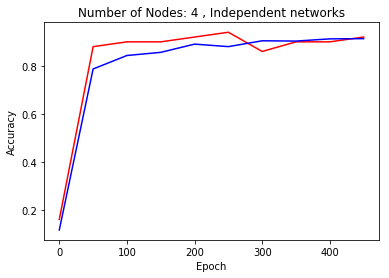

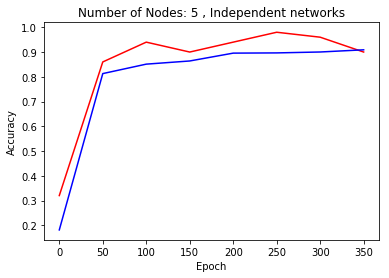

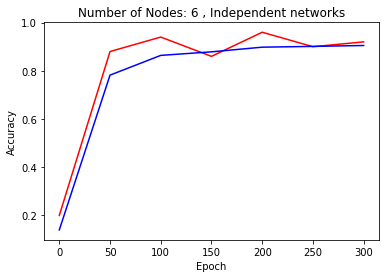

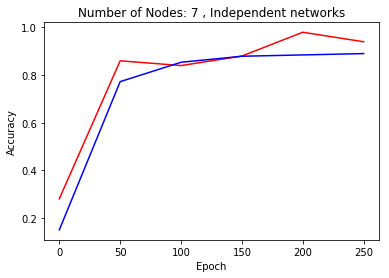

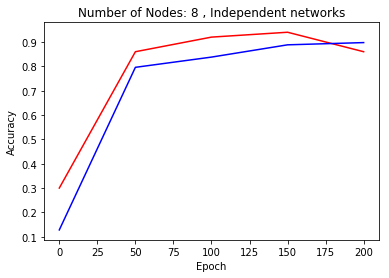

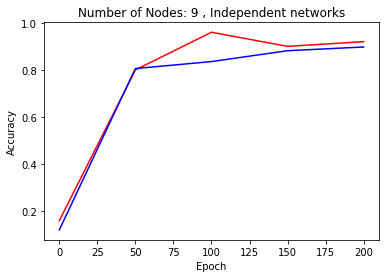

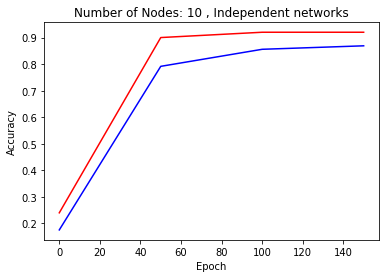

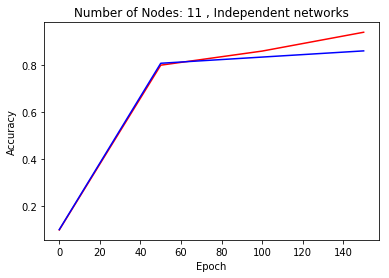

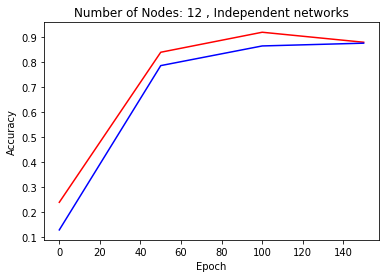

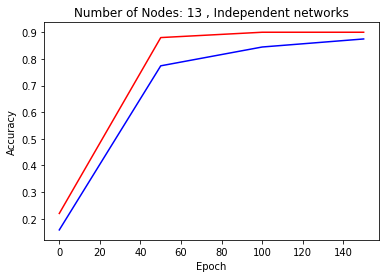

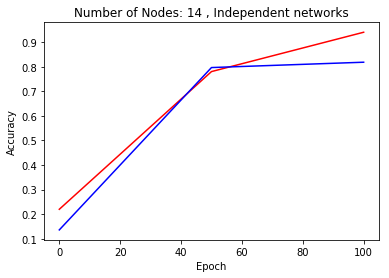

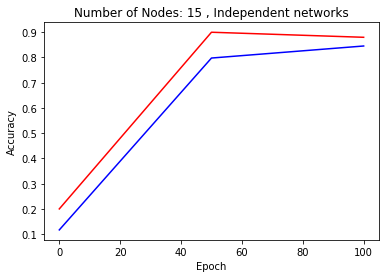

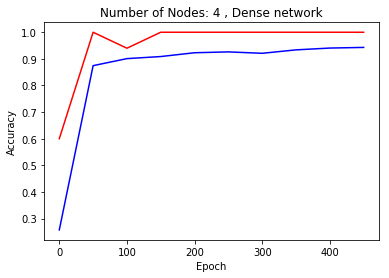

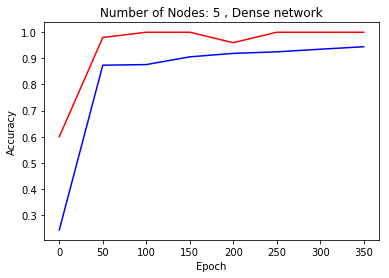

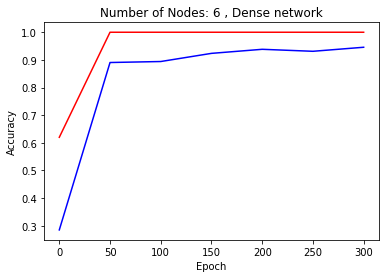

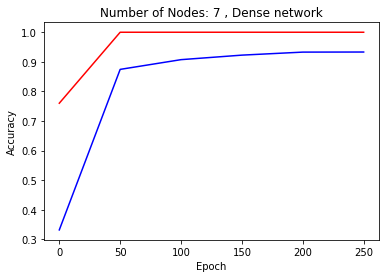

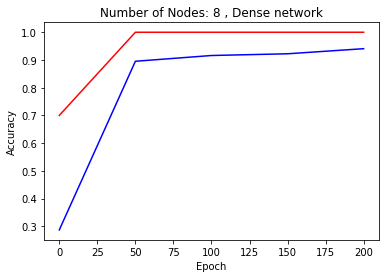

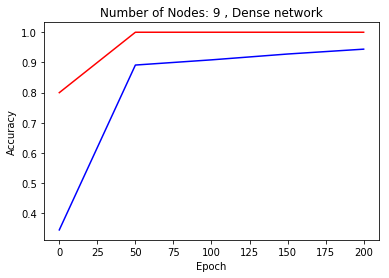

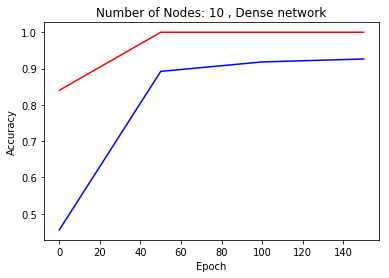

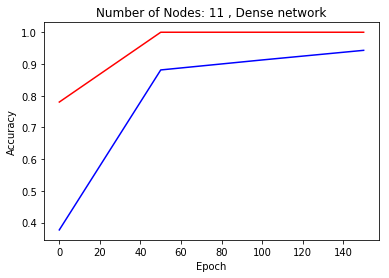

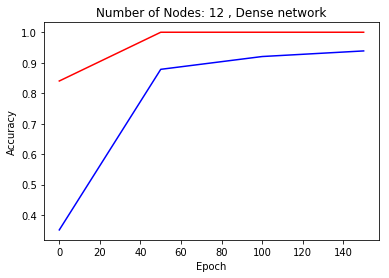

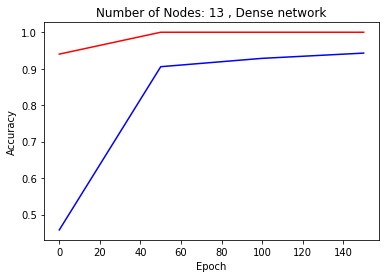

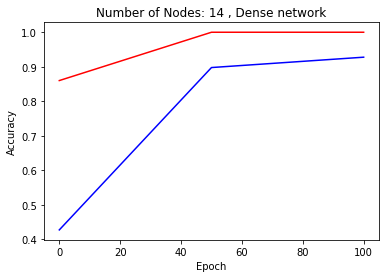

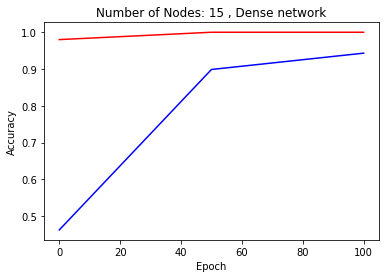

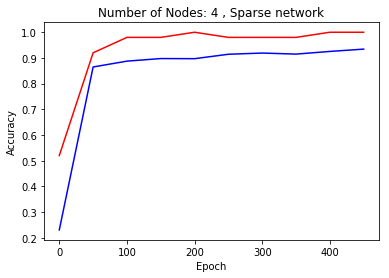

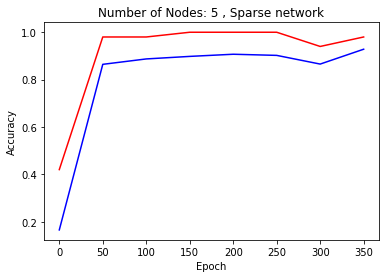

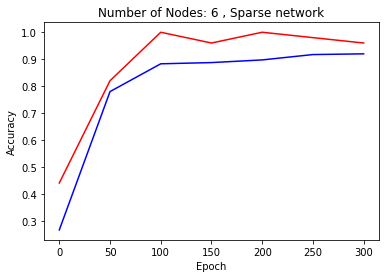

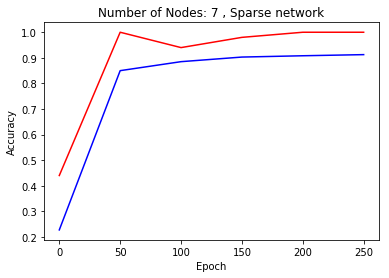

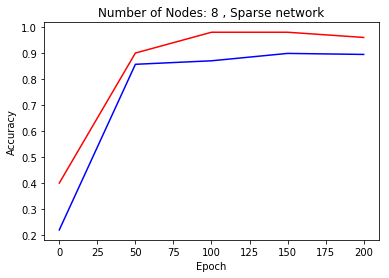

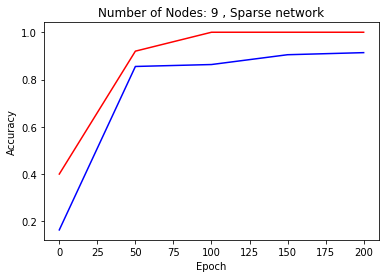

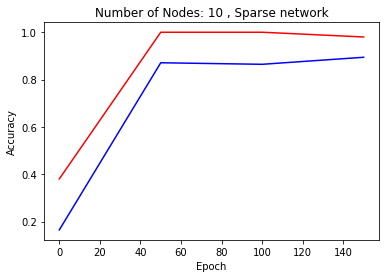

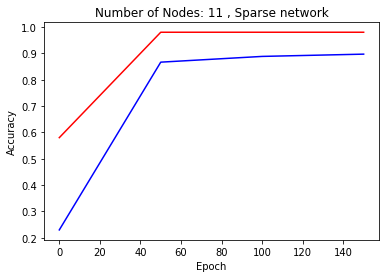

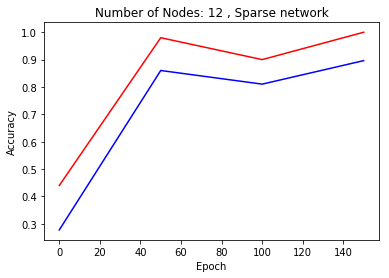

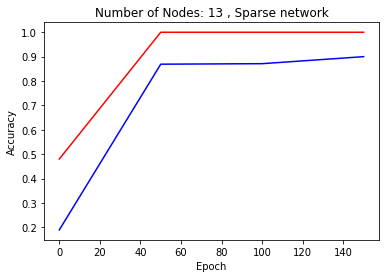

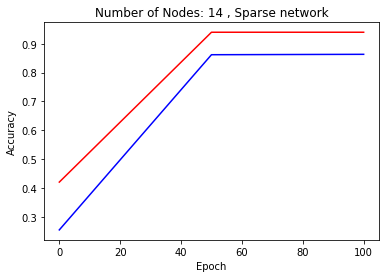

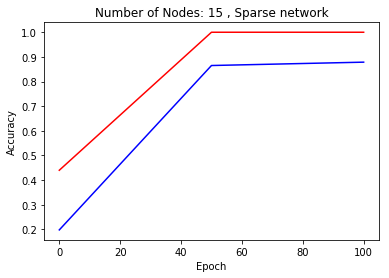

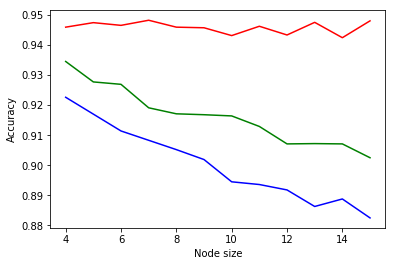

In [2]:
#TODO:add more error bars (for all of graphs) 
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.pyplot as plt
%matplotlib inline

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True

#Helper function to swap identities of gradients from one to the other.
def swapIdentity(gradient, newIdentity):
    return (gradient[0], newIdentity) #return new tuple with the identity replaced

def shp(x):
    return np.shape(x) 

#-----------------------Initialization---------------------------
#Hyperparameters:
theta_D = 1 #download rate
theta_U = 0.01 #Upload rate

#sz = 4 # size of network
node_sz = []
accs = []

node_sz_fully = []
accs_fully = []

node_sz_indiv = []
accs_indiv = []
plots = 0

for architecture in range(3): #0 = dense graph N(N-1)/2 connections, #1 = sparse graph (N connections), #3 = independent 
    for sz in range(4,16):
        
        tf.reset_default_graph()

        # Variables for our  4- way network
        W1 = [tf.Variable(tf.truncated_normal([784, 500], stddev=0.1)) for i in range(sz)]
        b1 = [tf.Variable(tf.zeros([500]))                             for i in range(sz)]
        W2 = [tf.Variable(tf.truncated_normal([500, 100], stddev=0.1)) for i in range(sz)]
        b2 = [tf.Variable(tf.zeros([100]))                             for i in range(sz)]
        W3 = [tf.Variable(tf.truncated_normal([100, 10], stddev=0.1))  for i in range(sz)]
        b3 = [tf.Variable(tf.zeros([10]))                              for i in range(sz)]

        #Temporary gradient banks for communication between nodes (noise may be added in future)
        g_W1 = [None for i in range(sz)]
        g_W2 = [None for i in range(sz)]
        g_W3 = [None for i in range(sz)]
        g_b1 = [None for i in range(sz)]
        g_b2 = [None for i in range(sz)]
        g_b3 = [None for i in range(sz)]


        grad_W1 = [[None for i in range(sz)] for i in range(sz)]
        grad_W2 = [[None for i in range(sz)] for i in range(sz)]
        grad_W3 = [[None for i in range(sz)] for i in range(sz)]
        grad_b1 = [[None for i in range(sz)] for i in range(sz)]
        grad_b2 = [[None for i in range(sz)] for i in range(sz)]
        grad_b3 = [[None for i in range(sz)] for i in range(sz)]


        #hidden layers, scores, etc. *Note there is somehow a problem with saying scores = loss = [None for i in range(sz)] so I put them in seperate lines
        h1 = [None for i in range(sz)]
        h2 = [None for i in range(sz)]

        scores = [None for i in range(sz)]
        loss = [None for i in range(sz)]

        #-------------------------Define Decentralized Neural Network Structure-----------------

        # Placeholders
        X = [tf.placeholder(tf.float32, [None, 784])  for i in range(sz)]
        y = [tf.placeholder(tf.float32, [None, 10])    for i in range(sz)]


        # Deep Neural nets for 4 channels w/ loss function
        for i in range(sz):
            h1[i] = tf.nn.relu(tf.matmul(X[i],  W1[i]) + b1[i])
            h2[i] = tf.nn.relu(tf.matmul(h1[i], W2[i]) + b2[i])
            scores[i] = tf.matmul(h2[i], W3[i]) + b3[i]
            loss[i] = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=scores[i], labels=y[i]))

        # Gradient descent for 4 channels
        train_one_step = [None for i in range(sz)]
        opt =[None for i in range(sz)]

        for i in range(sz):
            opt[i] = tf.train.GradientDescentOptimizer(0.05)
            train_one_step[i] = opt[i].minimize(loss[i])



        correct_predictions = [0.0 for i in range(sz)]
        accuracy = [0.0 for i in range(sz)]

        # Accuracy indicator for 4 channels
        for i in range(sz):
            correct_predictions[i] = tf.equal(tf.argmax(scores[i], axis=1), tf.argmax(y[i], axis=1))
            accuracy[i] = tf.reduce_mean(tf.cast(correct_predictions[i], tf.float32))

        # Initialization of all decleared Tensors (above) in Tensorflow
        init = tf.global_variables_initializer()

        # Training
        sess = tf.Session()
        sess.run(init) #initalize all variables

        #Gradient "bank"

        train_acc=[0.0 for i in range(sz)]
        train_loss=[0.0 for i in range(sz)]
        test_acc = [0.0 for i in range(sz)]

        send_gradients = [None for i in range(sz)]

        #-----------------Build the gradients transfer graph---------------------
        for cnode in range(sz):
            #compute local gradients
            g_W1[cnode], g_W2[cnode], g_W3[cnode], g_b1[cnode], g_b2[cnode], g_b3[cnode] = opt[cnode].compute_gradients(
                    loss=loss[cnode], var_list=[W1[cnode], W2[cnode], W3[cnode], b1[cnode], b2[cnode], b3[cnode]])

            #EXperimennt around with either 1)dense, N(N-1)/2 connections, or 2)sparse graph, N connections
            #for nei in range(sz): #Dense graph
            if(architecture == 1):
                neighbors = range(sz)
            elif(architecture == 2):
                neighbors = [(cnode+1) % sz, cnode, (sz + cnode - 1) % sz]
            else:
                neighbors = [cnode]
            
            allgrads = []
            for nei in neighbors:
                #Distribute local gradients from current node to neighboring nodes
                grad_W1[cnode][nei] = swapIdentity(g_W1[cnode], W1[nei])
                grad_W2[cnode][nei] = swapIdentity(g_W2[cnode], W2[nei])
                grad_W3[cnode][nei] = swapIdentity(g_W3[cnode], W3[nei])
                grad_b1[cnode][nei] = swapIdentity(g_b1[cnode], b1[nei])
                grad_b2[cnode][nei] = swapIdentity(g_b2[cnode], b2[nei])
                grad_b3[cnode][nei] = swapIdentity(g_b3[cnode], b3[nei])
                allgrads += [grad_W1[cnode][nei],grad_W2[cnode][nei],grad_W3[cnode][nei],
                             grad_b1[cnode][nei],grad_b2[cnode][nei],grad_b3[cnode][nei]]

            send_gradients[cnode] = opt[cnode].apply_gradients(allgrads)
        #------------------------------Begin Training------------------------------

        #NOTE only for the first node (cnode = 0)
        x_train = []
        y_train = []

        x_test = []
        y_test = []

        #Split data into 4-ths. (50,50,50,50)

        for i in range(2000 // sz):

            for cnode in range(sz):      
                #---------download minibatch of 50 & get gradients-----------------------
                X_batch, y_batch = mnist.train.next_batch(50)

                #send gradients computed from current node to neighbors
                if(architecture == 1):
                    neighbors = range(sz)
                elif(architecture == 2):
                    neighbors = [(cnode+1) % sz, cnode, (sz + cnode - 1) % sz]
                else: #arch = 0: indiviaul
                    neighbors = [cnode]
                    
                for nei in neighbors:
                #for nei in range(sz):
                    sess.run(send_gradients[cnode], feed_dict={X[cnode]: X_batch, y[cnode]: y_batch})



                if(i % 50 == 0):
                    train_acc[cnode] = sess.run(accuracy[cnode], feed_dict={X[cnode]: X_batch, y[cnode]: y_batch})
                    test_acc[cnode] = sess.run(accuracy[cnode], feed_dict={X[cnode]: mnist.test.images, y[cnode]: mnist.test.labels})
                    #PLOT ACCURACY OF FIRST NODE
                    if(cnode == 0):
                        x_train += [i]
                        y_train += [train_acc[cnode]]

                        x_test += [i]
                        y_test += [test_acc[cnode]]
                    print("accuracy for Node: ", cnode,  "  is: ",train_acc[cnode],  "  at epoch: ", i, " test acc: ", test_acc[cnode])

        #after done with training (for i loop), get FINAL test set accuracy for export.
        plots+=1
        plt.figure(plots)
        
        arch = ''
        if(architecture == 1):
            arch = "Dense network"
        elif(architecture == 2):
            arch = "Sparse network"
        else:
            arch = "Independent networks"
        
        plt.title("Number of Nodes: " +str(sz) + " , " + arch)
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.plot(x_train, y_train, 'r', x_test, y_test, 'b')

        maxacc = 0
        # Make sure to print out your accuracy on the test set at the end.
        print("Final accuracy on test set:")
        for i in range(sz):
            accy =  sess.run(accuracy[i], feed_dict={X[i]: mnist.test.images, y[i]: mnist.test.labels})
            print(i, " has accuracy: ",accy)
            maxacc = max(maxacc, accy)
        
        
        if(architecture == 1): #arch = 1: fully
            node_sz_fully += [sz]
            accs_fully += [maxacc]
        elif(architecture == 2): #arch = 2: sparse graph
            node_sz += [sz]
            accs += [maxacc]
        else: #arch = 0: individual
            node_sz_indiv += [sz]
            accs_indiv += [maxacc]

#FINAL PLOT for the #of Agents (Node size) vs. accuracy (max of all agents) 
plt.figure(plots+1)
plt.xlabel('Node size')
plt.ylabel('Accuracy')
#GREEN: sparse results RED: dense results BLUE: individual results
plt.plot(node_sz, accs, 'g', node_sz_fully, accs_fully, 'r', node_sz_indiv, accs_indiv, 'b')
